In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.formula.api as smf

from config.database import execute_query
from datetime import datetime, timedelta
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import grangercausalitytests

In [2]:
print("A carregar dados da base de dados PostgreSQL...")

# Query para obter todos os posts
posts_query = "SELECT id, symbol, post_id, post_author, post_date, post_text, post_likes, post_comments, post_reshares, sentiment FROM public.stocktwits_posts;"
posts_data = execute_query(posts_query)
posts_df = pd.DataFrame(posts_data)

# Query para obter todos os autores
authors_query = "SELECT id, author, total_followers, total_following, avg_likes, avg_comments, avg_reshares FROM public.stocktwits_authors;"
authors_data = execute_query(authors_query)
authors_df = pd.DataFrame(authors_data)

# Converter tipos de dados para otimização
posts_df['post_date'] = pd.to_datetime(posts_df['post_date'])

print(f"{len(posts_df)} posts e {len(authors_df)} autores carregados com sucesso.")

A carregar dados da base de dados PostgreSQL...
1011422 posts e 57470 autores carregados com sucesso.


In [3]:
# Obter a lista de símbolos únicos a partir dos posts
SYMBOLS = posts_df['symbol'].unique()

# Definir o período com base nas datas dos posts
START_DATE = pd.Timestamp('2024-12-01')
END_DATE = posts_df['post_date'].max() + timedelta(days=1)

# Dicionário para armazenar dados de cada ação
stock_data = {}

In [4]:
print("A recolher dados de mercado...")

symbols_error = []

for symbol in SYMBOLS:
    try:
        ticker = yf.Ticker(symbol)
        hist = ticker.history(start=START_DATE.strftime('%Y-%m-%d'), 
                              end=END_DATE.strftime('%Y-%m-%d'))
        
        if not hist.empty:
            hist['Return'] = hist['Close'].pct_change()
            hist['Volatility_20d'] = hist['Return'].rolling(window=20).std() * (252 ** 0.5)
            stock_data[symbol] = hist
            print(f"Dados para {symbol} recolhidos.")
        else:
            symbols_error.append(symbol)
            print(f"Não foram encontrados dados para {symbol} no yfinance.")
    except Exception as e:
        symbols_error.append(symbol)
        print(f"Erro ao recolher dados para {symbol}: {e}")

A recolher dados de mercado...
Dados para ^SPX recolhidos.
Dados para AAPL recolhidos.
Dados para TSLA recolhidos.
Dados para NVDA recolhidos.
Dados para BTC-USD recolhidos.
Dados para META recolhidos.
Dados para DOGE-USD recolhidos.
Dados para SOL-USD recolhidos.
Dados para ETH-USD recolhidos.
Dados para BNB-USD recolhidos.
Dados para GOOGL recolhidos.
Dados para AMZN recolhidos.
Dados para NIO recolhidos.
Dados para MSFT recolhidos.
Dados para GOOG recolhidos.
Dados para INTC recolhidos.
Dados para AMD recolhidos.
Dados para NFLX recolhidos.
Dados para SPY recolhidos.
Dados para XRP-USD recolhidos.
Dados para BLK recolhidos.
Dados para IBM recolhidos.
Dados para AAL recolhidos.
Dados para BAC recolhidos.
Dados para BABA recolhidos.
Dados para BYDDF recolhidos.
Dados para XPEV recolhidos.
Dados para BYDDY recolhidos.
Dados para QQQ recolhidos.
Dados para LCID recolhidos.
Dados para DIA recolhidos.
Dados para F recolhidos.
Dados para RTX recolhidos.
Dados para JD recolhidos.
Dados para

In [8]:
# Verificar simbolos que falharam
symbols_error

[]

In [5]:
print("A calcular métricas de influência...")

# Calcular contagem de posts por autor
post_counts = posts_df.groupby('post_author')['id'].count().reset_index(name='post_count')

# Juntar a contagem de posts com os dados dos autores
authors_metrics_df = authors_df.merge(post_counts, left_on='author', right_on='post_author', how='left')
authors_metrics_df['post_count'] = authors_metrics_df['post_count'].fillna(0)

# Calcular ratio de influência (evitando divisão por zero)

authors_metrics_df = authors_metrics_df.drop(columns=['post_author'])
authors_metrics_df['influence_ratio'] = authors_metrics_df['total_followers'] / authors_metrics_df['total_following'].replace(0, 1)

print("Métricas de influência calculadas.")

authors_metrics_df

A calcular métricas de influência...
Métricas de influência calculadas.


id              author  total_followers  total_following  avg_likes  \
0      30081            gbub2315                0                0          0   
1          2           OneTime19                7                4          0   
2          4         Absurdity54                9                3          3   
3          6  BattagliaInvesting               58              102          1   
4          7             twincam               79               20          3   
...      ...                 ...              ...              ...        ...   
57465  22947         Charles5211                4               16          1   
57466  22878         JakeInvests               12                1          4   
57467  22913          nguwinning               38                0          0   
57468  22914         Memecoinsss               43                4          2   
57469  22844     Hollywood_Hogan                9               11          5   

       avg_comments  avg_reshares  post_count  influence_ratio  
0                 0             0           1         0.000000  
1                 0             0           5         1.750000  
2                 2             0           5         3.000000  
3                 0             0           9         0.568627  
4                 1             0          53         3.950000  
...             ...           ...         ...              ...  
57465             0             0           1         0.250000  
57466             0             0          16        12.000000  
57467             0             0           1        38.000000  
57468             1             0           6        10.750000  
57469             0             0           1         0.818182  

[57470 rows x 9 columns]

In [6]:
# Identificar posts originais (que não contêm '@')
posts_df['is_reply'] = posts_df['post_text'].str.contains('@', regex=False)

# Contar posts originais por autor
parent_counts = posts_df[~posts_df['is_reply']].groupby('post_author').size().reset_index(name='parent_count')

# Adicionar à tabela de métricas
authors_metrics_df = authors_metrics_df.merge(parent_counts, left_on='author', right_on='post_author', how='left')
authors_metrics_df['parent_count'] = authors_metrics_df['parent_count'].fillna(0)
authors_metrics_df = authors_metrics_df.drop(columns=['post_author'])

print("Métrica 'Parent' calculada.")

authors_metrics_df

Métrica 'Parent' calculada.


id              author  total_followers  total_following  avg_likes  \
0      30081            gbub2315                0                0          0   
1          2           OneTime19                7                4          0   
2          4         Absurdity54                9                3          3   
3          6  BattagliaInvesting               58              102          1   
4          7             twincam               79               20          3   
...      ...                 ...              ...              ...        ...   
57465  22947         Charles5211                4               16          1   
57466  22878         JakeInvests               12                1          4   
57467  22913          nguwinning               38                0          0   
57468  22914         Memecoinsss               43                4          2   
57469  22844     Hollywood_Hogan                9               11          5   

       avg_comments  avg_reshares  post_count  influence_ratio  parent_count  
0                 0             0           1         0.000000           1.0  
1                 0             0           5         1.750000           5.0  
2                 2             0           5         3.000000           5.0  
3                 0             0           9         0.568627           9.0  
4                 1             0          53         3.950000          52.0  
...             ...           ...         ...              ...           ...  
57465             0             0           1         0.250000           1.0  
57466             0             0          16        12.000000          16.0  
57467             0             0           1        38.000000           1.0  
57468             1             0           6        10.750000           6.0  
57469             0             0           1         0.818182           1.0  

[57470 rows x 10 columns]

In [7]:
def calculate_sentiment_impact(posts_df, post_author, hours_window=24, min_subseq=5, min_pairs=10):
    """
    Calcula o impacto do sentimento de um autor sobre o sentimento subsequente da comunidade
    """
    # Mensagens do autor
    author_messages = posts_df[posts_df['post_author'] == post_author]

    impact_scores = []

    for _, message in author_messages.iterrows():
        start_time = message['post_date']
        end_time = start_time + pd.Timedelta(hours=hours_window)
        user_sentiment = message['sentiment_value']
        
        # Mensagens subsequentes do mesmo símbolo, excluindo o próprio autor
        subsequent_messages = posts_df[
            (posts_df['post_date'] > start_time) &
            (posts_df['post_date'] <= end_time) &
            (posts_df['post_author'] != post_author) &
            (posts_df['symbol'] == message['symbol'])
        ]

        if len(subsequent_messages) >= min_subseq:
            subsequent_sentiment = subsequent_messages['sentiment_value'].mean()
            impact_scores.append((user_sentiment, subsequent_sentiment))

    if len(impact_scores) >= min_pairs:
        user_sentiments, subsequent_sentiments = zip(*impact_scores)
        # Protege contra casos em que todos valores são iguais
        try:
            pearson_corr, _ = pearsonr(user_sentiments, subsequent_sentiments)
        except Exception:
            pearson_corr = np.nan

        return pearson_corr
    else:
        return np.nan

In [8]:
print("A segmentar autores e posts por influência...")

# Normalizar métricas para criar um score composto
metrics_to_normalize = ['total_followers', 'influence_ratio', 'post_count', 'parent_count', 'avg_likes', 'avg_comments', 'avg_reshares']
for metric in metrics_to_normalize:
    # Verificar se a coluna existe e não está vazia
    if metric in authors_metrics_df.columns and not authors_metrics_df[metric].isnull().all():
        min_val = authors_metrics_df[metric].min()
        max_val = authors_metrics_df[metric].max()
        if max_val > min_val:
            authors_metrics_df[f'{metric}_norm'] = (authors_metrics_df[metric] - min_val) / (max_val - min_val)
        else:
            authors_metrics_df[f'{metric}_norm'] = 0
    else:
        authors_metrics_df[f'{metric}_norm'] = 0

# Criar score de influência composto (pesos podem ser ajustados)
authors_metrics_df['influence_score'] = (
    authors_metrics_df['total_followers_norm'] * 0.4 +
    authors_metrics_df['influence_ratio_norm'] * 0.1 +
    authors_metrics_df['post_count_norm'] * 0.15 +
    authors_metrics_df['parent_count_norm'] * 0.2 +
    authors_metrics_df['avg_likes_norm'] * 0.05 +
    authors_metrics_df['avg_comments_norm'] * 0.05 +
    authors_metrics_df['avg_reshares_norm'] * 0.05
)

# Classificar autores em categorias de influência
authors_metrics_df['influence_category'] = pd.qcut(
    authors_metrics_df['influence_score'].rank(method='first'), 
    q=[0, .90, .95, .99, 1.], 
    labels=['regular', 'influential', 'highly_influential', 'top_influencer']
)

authors_metrics_df

A segmentar autores e posts por influência...


id              author  total_followers  total_following  avg_likes  \
0      30081            gbub2315                0                0          0   
1          2           OneTime19                7                4          0   
2          4         Absurdity54                9                3          3   
3          6  BattagliaInvesting               58              102          1   
4          7             twincam               79               20          3   
...      ...                 ...              ...              ...        ...   
57465  22947         Charles5211                4               16          1   
57466  22878         JakeInvests               12                1          4   
57467  22913          nguwinning               38                0          0   
57468  22914         Memecoinsss               43                4          2   
57469  22844     Hollywood_Hogan                9               11          5   

       avg_comments  avg_reshares  post_count  influence_ratio  parent_count  \
0                 0             0           1         0.000000           1.0   
1                 0             0           5         1.750000           5.0   
2                 2             0           5         3.000000           5.0   
3                 0             0           9         0.568627           9.0   
4                 1             0          53         3.950000          52.0   
...             ...           ...         ...              ...           ...   
57465             0             0           1         0.250000           1.0   
57466             0             0          16        12.000000          16.0   
57467             0             0           1        38.000000           1.0   
57468             1             0           6        10.750000           6.0   
57469             0             0           1         0.818182           1.0   

       total_followers_norm  influence_ratio_norm  post_count_norm  \
0                  0.000000              0.000000         0.000000   
1                  0.000022              0.000011         0.000757   
2                  0.000028              0.000018         0.000757   
3                  0.000182              0.000003         0.001515   
4                  0.000247              0.000024         0.009845   
...                     ...                   ...              ...   
57465              0.000013              0.000002         0.000000   
57466              0.000038              0.000073         0.002840   
57467              0.000119              0.000230         0.000000   
57468              0.000135              0.000065         0.000947   
57469              0.000028              0.000005         0.000000   

       parent_count_norm  avg_likes_norm  avg_comments_norm  \
0               0.000191        0.000000           0.000000   
1               0.000953        0.000000           0.000000   
2               0.000953        0.050000           0.042553   
3               0.001715        0.016667           0.000000   
4               0.009909        0.050000           0.021277   
...                  ...             ...                ...   
57465           0.000191        0.016667           0.000000   
57466           0.003049        0.066667           0.000000   
57467           0.000191        0.000000           0.000000   
57468           0.001143        0.033333           0.021277   
57469           0.000191        0.083333           0.000000   

       avg_reshares_norm  influence_score influence_category  
0                    0.0         0.000038            regular  
1                    0.0         0.000314            regular  
2                    0.0         0.004945            regular  
3                    0.0         0.001477            regular  
4                    0.0         0.007124            regular  
...                  ...              ...                ...  
57465                0.0         0.00

In [9]:
# Juntar a categoria de influência aos posts
posts_with_influence_df = posts_df.merge(
    authors_metrics_df[['author', 'influence_category']], 
    left_on='post_author', 
    right_on='author', 
    how='left'
)

# Adicionar 'unknown' às categorias se necessário
if hasattr(posts_with_influence_df['influence_category'].dtype, 'categories'):
    if 'unknown' not in posts_with_influence_df['influence_category'].cat.categories:
        posts_with_influence_df['influence_category'] = posts_with_influence_df['influence_category'].cat.add_categories(['unknown'])

posts_with_influence_df['influence_category'] = posts_with_influence_df['influence_category'].fillna('unknown')

print("Segmentação concluída.")

posts_with_influence_df

Segmentação concluída.


id    symbol    post_id             post_author  \
0          93235      ^SPX  607651710                 Ugiagbe   
1          93237      ^SPX  607651042  SPYder_QQQueen_Trading   
2          93243      ^SPX  607650950                Armencho   
3              2      AAPL  607389446     NinjaBaseballBatMan   
4              3      AAPL  607389425           Michael_H_007   
...          ...       ...        ...                     ...   
1011417  1011255  SHIB-USD  617960755        BozoJoeClownShow   
1011418  1011258  SHIB-USD  617960135             GoodluckOTC   
1011419  1011259  SHIB-USD  617960118             GoodluckOTC   
1011420  1011261  SHIB-USD  617960101             GoodluckOTC   
1011421  1011264  SHIB-USD  617959762             FirstMileMD   

                  post_date  \
0       2025-03-11 16:18:56   
1       2025-03-11 16:15:27   
2       2025-03-11 16:14:58   
3       2025-03-10 00:34:10   
4       2025-03-10 00:33:54   
...                     ...   
1011417 2025-06-15 12:18:59   
1011418 2025-06-15 11:47:16   
1011419 2025-06-15 11:46:12   
1011420 2025-06-15 11:45:10   
1011421 2025-06-15 11:19:26   

                                                 post_text  post_likes  \
0        $SPX WTH…. No one can trade the market because...           0   
1        $SPY $SPX $QQQ This market is going to make me...           0   
2                     $SPX all I have double my long calls           0   
3            $AAPL\n $DJT\n $SPY\n $TSLA\n Bulls \nBearish           0   
4        $TSLA\n $DJT\n $SPY\n $AAPL\n  \nmsnbc.com/opi...           0   
...                                                    ...         ...   
1011417  $SHIB.X \n\nlook at the posts on X by Shytoshi...           2   
1011418  $SHIB.X 2024 LOGIC: \n \n                     ...           1   
1011419  $SHIB.X 2024 LOGIC: \n \n                     ...           1   
1011420  $SHIB.X 2024 LOGIC: \n \n2025: "LMAO!!!!!!!!! ...           1   
1011421  $SHIB.X people lost a lot of money on this gar...           1   

         post_comments  post_reshares sentiment  is_reply  \
0                    0              0   BEARISH     False   
1                    0              0   BEARISH     False   
2                    0              0   BULLISH     False   
3                    0              0   BEARISH     False   
4                    0              0   BEARISH     False   
...                ...            ...       ...       ...   
1011417              2              0   BEARISH     False   
1011418              0              3   BEARISH     False   
1011419              0              3   BEARISH     False   
1011420              0              3   BULLISH      True   
1011421              1              0   BEARISH     False   

                         author influence_category  
0                       Ugiagbe            regular  
1        SPYder_QQQueen_Trading     top_influencer  
2                      Armencho     top_influencer  
3           NinjaBaseballBatMan            regular  
4                 Michael_H_007     top_influencer  
...                         ...                ...  
1011417        BozoJoeClownShow            regular  
1011418             GoodluckOTC     top_influencer  
1011419             GoodluckOTC     top_influencer  
1011420             GoodluckOTC     top_influencer  
1011421             FirstMileMD        influential  

[1011422 rows x 13 columns]

In [31]:
print("A preparar dados para análise de correlação...")

# Converter sentimento para valores numéricos
sentiment_map = {'BULLISH': 1, 'NEUTRAL': 0, 'BEARISH': -1}
posts_with_influence_df['sentiment_value'] = posts_with_influence_df['sentiment'].map(sentiment_map).fillna(0)

# Usar apenas a data (sem hora) para agregação
posts_with_influence_df['date'] = posts_with_influence_df['post_date'].dt.date

# Agregar sentimento por dia, símbolo e categoria de influência
sentiment_agg = posts_with_influence_df.groupby(['date', 'symbol', 'influence_category']).agg(
    sentiment_mean=('sentiment_value', 'mean'),
    sentiment_count=('sentiment_value', 'count'),
    bullish_ratio=('sentiment_value', lambda x: (x > 0).mean()),
    bearish_ratio=('sentiment_value', lambda x: (x < 0).mean())
).reset_index()

# Pivotar a tabela para ter categorias de influência como colunas
sentiment_pivot = sentiment_agg.pivot_table(
    index=['date', 'symbol'],
    columns='influence_category',
    values=['sentiment_mean', 'sentiment_count', 'bullish_ratio', 'bearish_ratio']
).reset_index()

# Achatar os nomes das colunas do multi-índice
sentiment_pivot.columns = ['_'.join(col).strip() for col in sentiment_pivot.columns.values]
sentiment_pivot = sentiment_pivot.rename(columns={'date_': 'date', 'symbol_': 'symbol'})

# Combinar dados de sentimento com dados de mercado
combined_data_list = []

for symbol, market_df in stock_data.items():
    market_df_reset = market_df.reset_index()
    market_df_reset['Date'] = pd.to_datetime(market_df_reset['Date']).dt.date
    
    symbol_sentiment = sentiment_pivot[sentiment_pivot['symbol'] == symbol]
    
    symbol_combined = pd.merge(
        market_df_reset,
        symbol_sentiment,
        left_on='Date',
        right_on='date',
        how='inner',
        validate='1:m'
    )
    combined_data_list.append(symbol_combined)

all_combined_df = pd.concat(combined_data_list, ignore_index=True)
# Calcular Capital Gains como variação percentual do preço de fechamento por símbolo
all_combined_df = all_combined_df.sort_values(['symbol', 'Date'])
all_combined_df['Capital Gains'] = all_combined_df.groupby('symbol')['Close'].pct_change()

all_combined_df

A preparar dados para análise de correlação...


/var/folders/pb/gbk2ys0x6gj9n78ydz98fs8r0000gp/T/ipykernel_99203/59519303.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_agg = posts_with_influence_df.groupby(['date', 'symbol', 'influence_category']).agg(
/var/folders/pb/gbk2ys0x6gj9n78ydz98fs8r0000gp/T/ipykernel_99203/59519303.py:19: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  sentiment_pivot = sentiment_agg.pivot_table(


Date         Open         High          Low        Close  \
5802  2024-12-01          NaN          NaN          NaN     0.000000   
5803  2024-12-02          NaN          NaN          NaN     0.000000   
5804  2024-12-03          NaN          NaN          NaN     0.000000   
5805  2024-12-04          NaN          NaN          NaN     0.000000   
5806  2024-12-05          NaN          NaN          NaN     0.000000   
...          ...          ...          ...          ...          ...   
129   2025-06-10  6009.910156  6043.009766  6000.279785  6038.810059   
130   2025-06-11  6049.379883  6059.399902  6002.319824  6022.240234   
131   2025-06-12  6009.899902  6045.430176  6003.879883  6045.259766   
132   2025-06-13  6000.560059  6026.160156  5963.209961  5976.970215   
133   2025-06-16  6004.000000  6050.830078  6004.000000  6033.109863   

          Volume  Dividends  Stock Splits    Return  Volatility_20d  ...  \
5802      235409        0.0           0.0       NaN             NaN  ...   
5803      189796        0.0           0.0       NaN             NaN  ...   
5804      186481        0.0           0.0       NaN             NaN  ...   
5805      220358        0.0           0.0       NaN             NaN  ...   
5806      146138        0.0           0.0       NaN             NaN  ...   
...          ...        ...           ...       ...             ...  ...   
129   4882880000        0.0           0.0  0.005483        0.118919  ...   
130   5111550000        0.0           0.0 -0.002744        0.117983  ...   
131   4669500000        0.0           0.0  0.003822        0.118356  ...   
132   5258910000        0.0           0.0 -0.011296        0.125900  ...   
133   5111710000        0.0           0.0  0.009393        0.127798  ...   

     sentiment_count_regular sentiment_count_influential  \
5802                     1.0                         0.0   
5803                     0.0                         0.0   
5804                     0.0                         1.0   
5805                     0.0                         0.0   
5806                     1.0                         0.0   
...                      ...                         ...   
129                     46.0                        13.0   
130                     27.0                         8.0   
131                     24.0                         6.0   
132                     37.0                        11.0   
133                      0.0                         0.0   

      sentiment_count_highly_influential  sentiment_count_top_influencer  \
5802                                 2.0                             0.0   
5803                                 0.0                             0.0   
5804                                 0.0                             0.0   
5805                                 0.0                             0.0   
5806                                 5.0                             0.0   
...                                  ...                             ...   
129                                 19.0                           111.0   
130                                 26.0                            98.0   
131                                 27.0                            70.0   
132                                 55.0                           126.0   
133                                  0.0                             0.0   

      sentiment_count_unknown  sentiment_mean_regular  \
5802                      0.0               -1.000000   
5803                      0.0                     NaN   
5804                      0.0                     NaN   
5805                      0.0                     NaN   
5806                      0.0                0.000000   
...                       ...                     ...   
129                       0.0                0.108696   
130                       0.0                0.185185   
131                       0.0               -0.333333   
132                       0.0 

In [32]:
all_combined_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Return', 'Volatility_20d', 'date', 'symbol',
       'bearish_ratio_regular', 'bearish_ratio_influential',
       'bearish_ratio_highly_influential', 'bearish_ratio_top_influencer',
       'bullish_ratio_regular', 'bullish_ratio_influential',
       'bullish_ratio_highly_influential', 'bullish_ratio_top_influencer',
       'sentiment_count_regular', 'sentiment_count_influential',
       'sentiment_count_highly_influential', 'sentiment_count_top_influencer',
       'sentiment_count_unknown', 'sentiment_mean_regular',
       'sentiment_mean_influential', 'sentiment_mean_highly_influential',
       'sentiment_mean_top_influencer', 'Capital Gains'],
      dtype='object')

Heatmap de correlação salvo como correlation_heatmap_postgresql.png


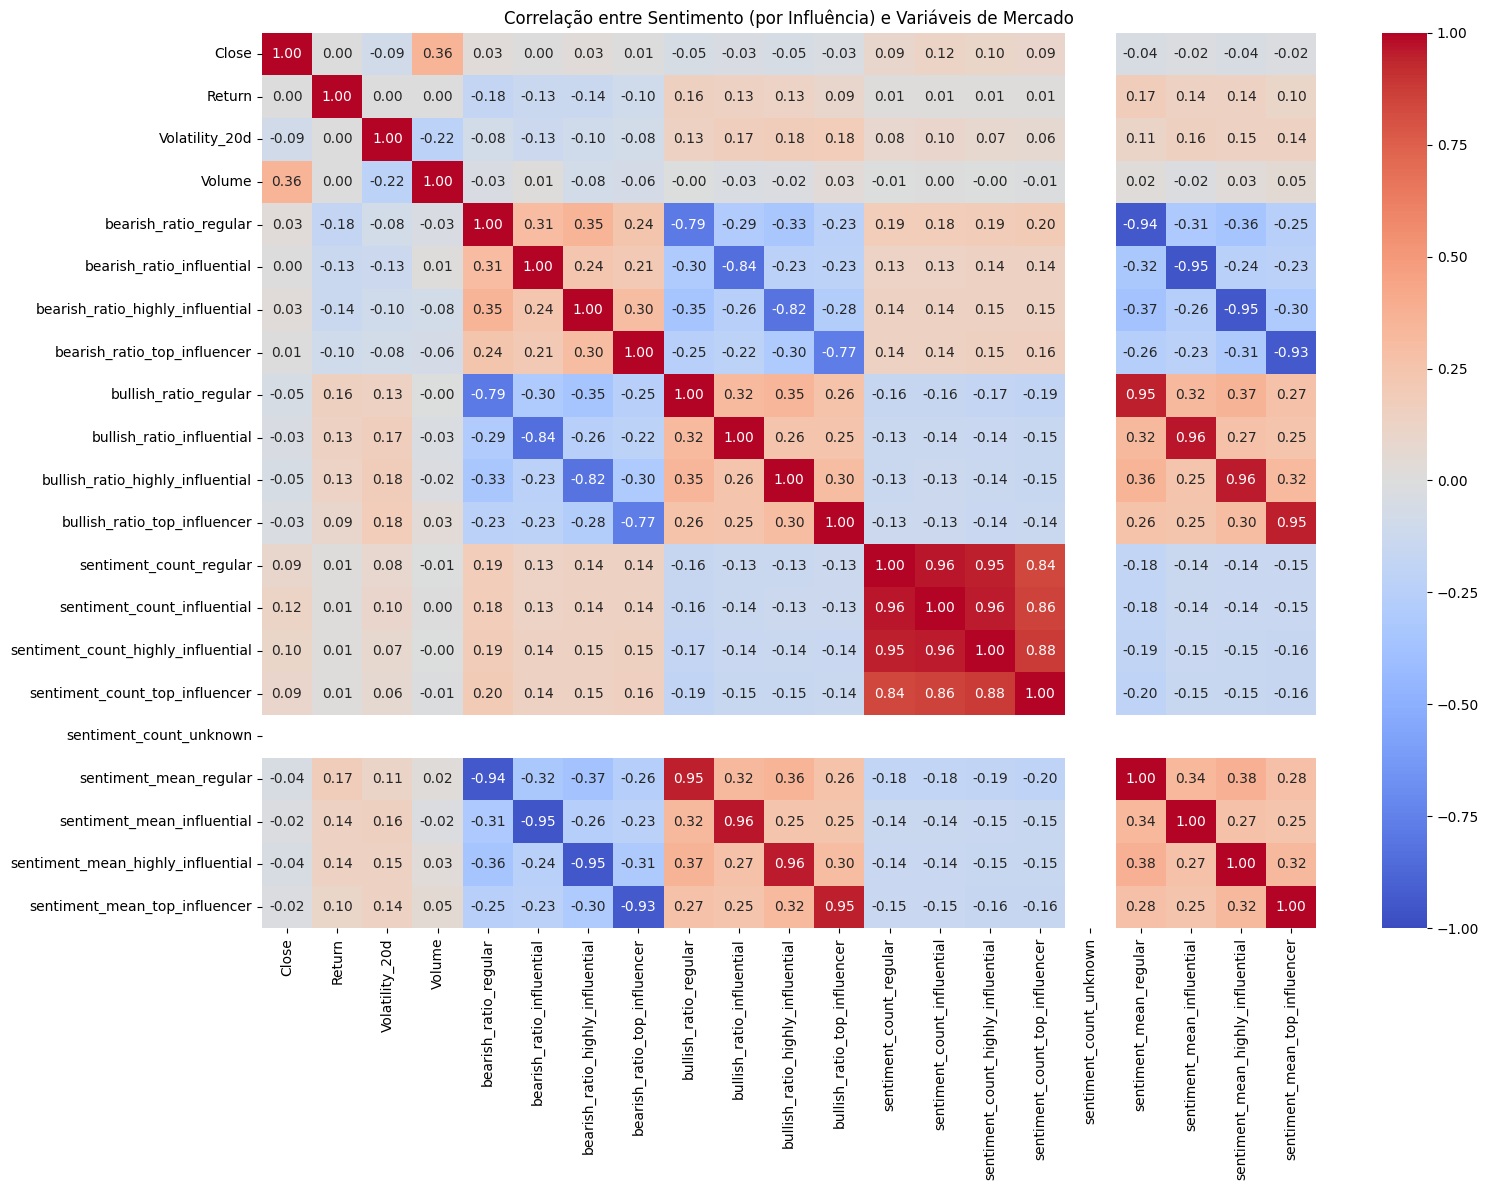

In [ ]:
# Verificar se o DataFrame combinado foi criado
if 'all_combined_df' in locals() and not all_combined_df.empty:
    # Definir variáveis de interesse
    market_vars = ['Close', 'Return', 'Volatility_20d', 'Volume']
    sentiment_vars = [col for col in all_combined_df.columns if 'sentiment' in col or 'ratio' in col]

    # Calcular e visualizar a matriz de correlação
    correlation_matrix = all_combined_df[market_vars + sentiment_vars].corr()

    plt.figure(figsize=(16, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
    plt.title('Correlação entre Sentimento (por Influência) e Variáveis de Mercado')
    plt.tight_layout()
    print("Heatmap de correlação salvo como correlation_heatmap_postgresql.png")
else:
    print("O DataFrame combinado está vazio. A análise de correlação não pode ser executada.")


/var/folders/pb/gbk2ys0x6gj9n78ydz98fs8r0000gp/T/ipykernel_99203/3579817801.py:39: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(
/var/folders/pb/gbk2ys0x6gj9n78ydz98fs8r0000gp/T/ipykernel_99203/3579817801.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, spearman_p = spearmanr(
/var/folders/pb/gbk2ys0x6gj9n78ydz98fs8r0000gp/T/ipykernel_99203/3579817801.py:39: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(
/var/folders/pb/gbk2ys0x6gj9n78ydz98fs8r0000gp/T/ipykernel_99203/3579817801.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, spearman_p = spearmanr(
/var/folders/pb/gbk2ys0x6gj9n78ydz98fs8r0000gp/T/ipykernel_99203/3579817801.py:39: ConstantInputWarning: An input array is constant; t

Teste de Granger: sentiment_mean_regular -> Close para TSLA
P-valores para lags 1-5: [0.29541918947531753, 0.049476741932978276, 0.16516182175078428, 0.10786410714692024, 0.4480319647638551]
Teste de Granger: sentiment_mean_influential -> Close para TSLA
P-valores para lags 1-5: [0.055213411734026795, 0.873009880367074, 0.7653120449577879, 0.9688186104134099, 0.7448913990564279]
Teste de Granger: bearish_ratio_top_influencer -> Close para NVDA
P-valores para lags 1-5: [0.06891182450131567, 0.43303333160745516, 0.31473027572263906, 0.45170505928255333, 0.616544488594071]
Teste de Granger: bullish_ratio_top_influencer -> Close para SOFI
P-valores para lags 1-5: [0.000950281971787148, 0.04996087368076181, 0.1695363515444977, 0.048663310626475796, 0.0006129924074983193]
Teste de Granger: sentiment_mean_top_influencer -> Close para NVDA
P-valores para lags 1-5: [0.206247675361381, 0.6024872153490604, 0.39968228654285054, 0.5188846164224072, 0.8082985553659134]


/Users/admin-wana/.pyenv/versions/3.11.5/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/admin-wana/.pyenv/versions/3.11.5/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


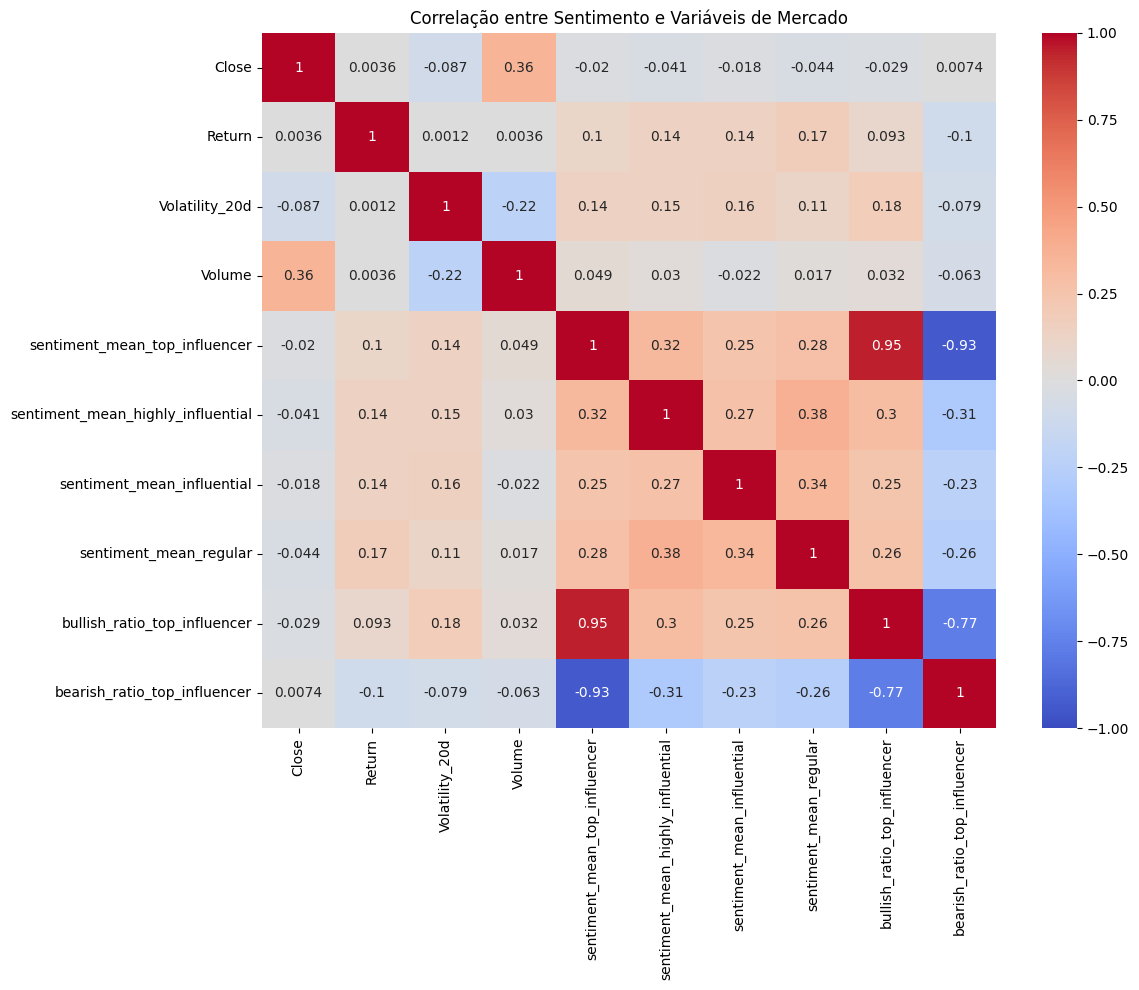

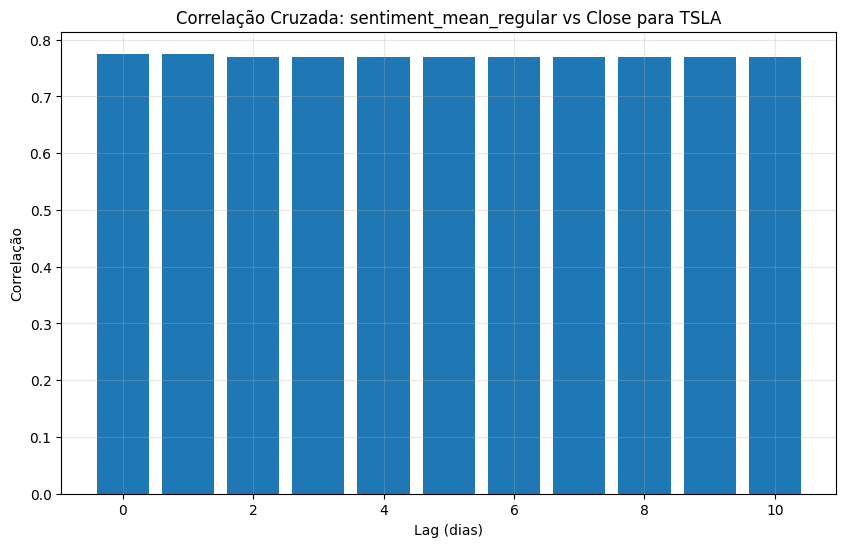

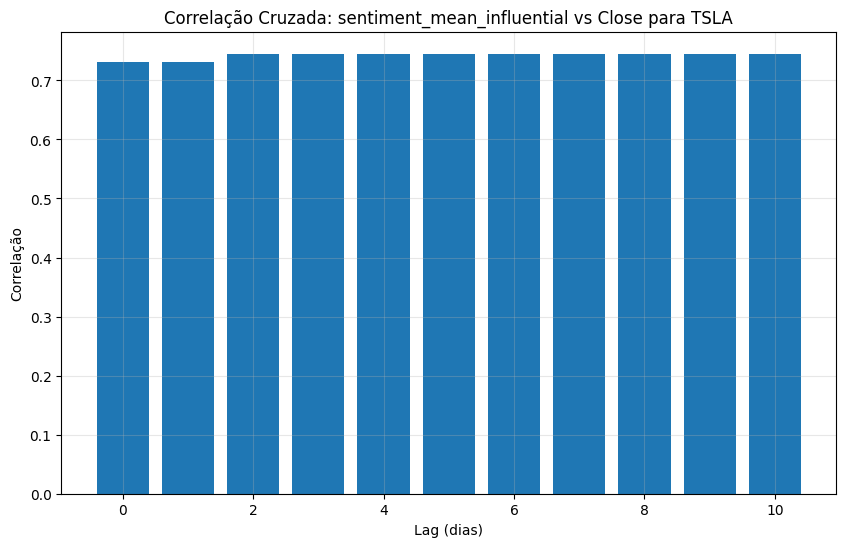

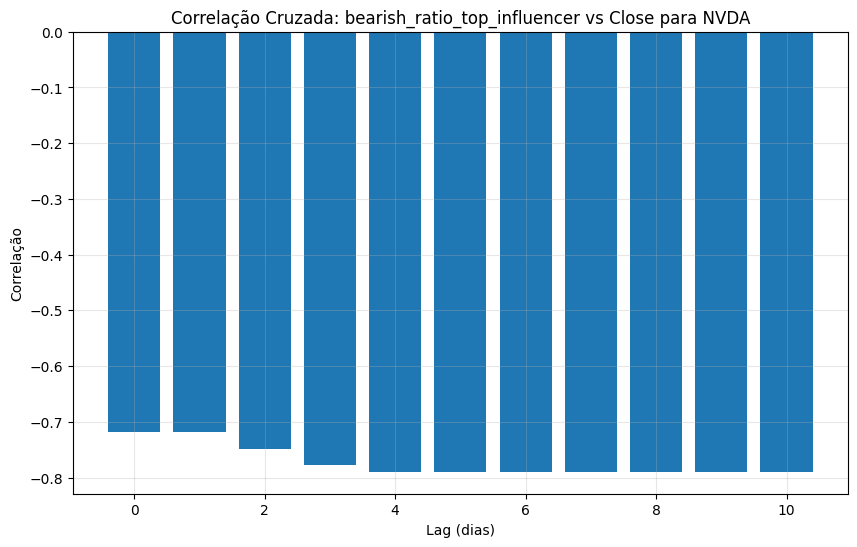

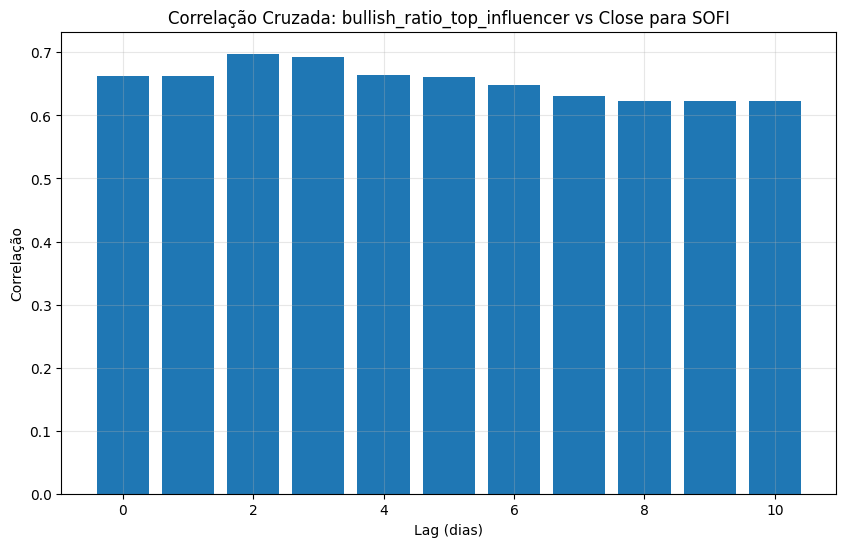

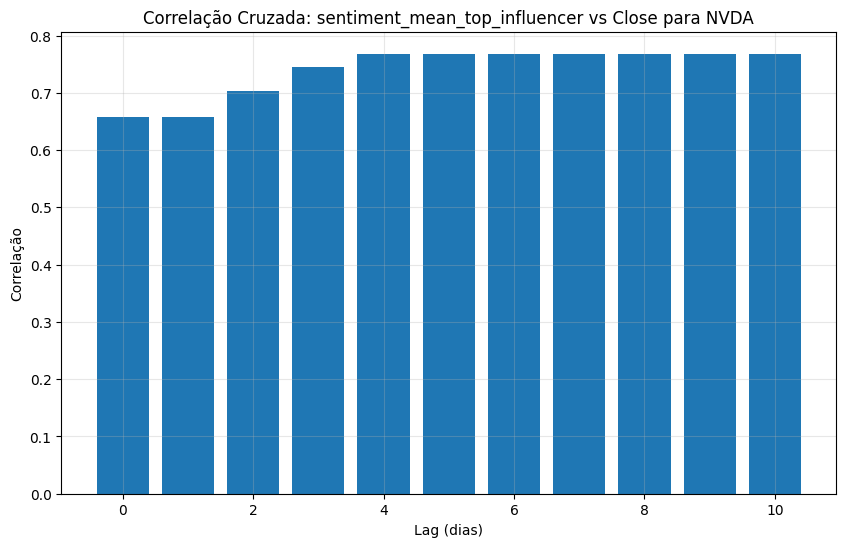

In [ ]:
# Definir variáveis de mercado de interesse
market_vars = ['Close', 'Return', 'Volatility_20d', 'Volume']

# Definir variáveis de sentimento de interesse (por categoria de influência)
sentiment_vars = [
    'sentiment_mean_top_influencer', 'sentiment_mean_highly_influential',
    'sentiment_mean_influential', 'sentiment_mean_regular',
    'bullish_ratio_top_influencer', 'bearish_ratio_top_influencer'
]

# Calcular matriz de correlação de Pearson
correlation_matrix = all_combined_df[market_vars + sentiment_vars].corr()

# Visualizar matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlação entre Sentimento e Variáveis de Mercado')
plt.tight_layout()

# Análise detalhada por símbolo
symbols = all_combined_df['symbol'].unique()
results = []

for symbol in symbols:
    symbol_data = all_combined_df[all_combined_df['symbol'] == symbol]
  
    for market_var in market_vars:
        for sentiment_var in sentiment_vars:
            # Remover NaNs e infs antes de calcular correlação
            valid = symbol_data[[sentiment_var, market_var]].dropna()
            # Remover infs
            valid = valid[
                (~valid[sentiment_var].isin([np.inf, -np.inf])) &
                (~valid[market_var].isin([np.inf, -np.inf]))
            ]
            if len(valid) > 1:
                # Correlação de Pearson
                pearson_corr, pearson_p = pearsonr(
                    valid[sentiment_var], 
                    valid[market_var]
                )
              
                # Correlação de Spearman
                spearman_corr, spearman_p = spearmanr(
                    valid[sentiment_var], 
                    valid[market_var]
                )
            else:
                pearson_corr, pearson_p = float('nan'), float('nan')
                spearman_corr, spearman_p = float('nan'), float('nan')
          
            # Adicionar aos resultados
            results.append({
                'symbol': symbol,
                'market_variable': market_var,
                'sentiment_variable': sentiment_var,
                'pearson_correlation': pearson_corr,
                'pearson_p_value': pearson_p,
                'spearman_correlation': spearman_corr,
                'spearman_p_value': spearman_p
            })

# Converter para DataFrame
results_df = pd.DataFrame(results)

# Filtrar correlações significativas (p < 0.05)
significant_results = results_df[
    (results_df['pearson_p_value'] < 0.05) | 
    (results_df['spearman_p_value'] < 0.05)
]

# Salvar resultados
results_df.to_csv("correlation_results.csv", index=False)
significant_results.to_csv("significant_correlations.csv", index=False)

# Análise de correlação cruzada (com lags) para os pares mais significativos
top_correlations = significant_results.sort_values('pearson_correlation', key=abs, ascending=False).head(5)

for _, row in top_correlations.iterrows():
    symbol = row['symbol']
    market_var = row['market_variable']
    sentiment_var = row['sentiment_variable']
  
    symbol_data = all_combined_df[all_combined_df['symbol'] == symbol]
  
    # Calcular correlação cruzada
    max_lag = 10  # Até 10 dias de lag
    cross_corr = []
    for lag in range(max_lag + 1):
        x = symbol_data[sentiment_var].iloc[lag:]
        y = symbol_data[market_var].iloc[:-lag if lag > 0 else None]
        # Garantir que x e y tenham o mesmo tamanho
        min_len = min(len(x), len(y))
        x = x.iloc[:min_len]
        y = y.iloc[:min_len]
        # Remover NaNs e infs
        valid = pd.DataFrame({sentiment_var: x, market_var: y}).dropna()
        valid = valid[
            (~valid[sentiment_var].isin([np.inf, -np.inf])) &
            (~valid[market_var].isin([np.inf, -np.inf]))
        ]
        if len(valid) > 1:
            corr = pearsonr(valid[sentiment_var], valid[market_var])[0]
        else:
            corr = np.nan
        cross_corr.append(corr)
  
    # Visualizar
    plt.figure(figsize=(10, 6))
    plt.bar(range(max_lag + 1), cross_corr)
    plt.xlabel('Lag (dias)')
    plt.ylabel('Correlação')
    plt.title(f'Correlação Cruzada: {sentiment_var} vs {market_var} para {symbol}')
    plt.grid(True, alpha=0.3)
  
    # Teste de causalidade de Granger
    granger_data = symbol_data[[sentiment_var, market_var]].dropna()
    try:
        granger_result = grangercausalitytests(granger_data, maxlag=5, verbose=False)
      
        # Extrair p-valores
        granger_p_values = [granger_result[i+1][0]['ssr_chi2test'][1] for i in range(5)]
      
        print(f"Teste de Granger: {sentiment_var} -> {market_var} para {symbol}")
        print(f"P-valores para lags 1-5: {granger_p_values}")
    except:
        print(f"Não foi possível realizar teste de Granger para {symbol}, {sentiment_var}, {market_var}")

Não há dados suficientes para regressão para este símbolo.
Quantil 0.1:
                         QuantReg Regression Results                          
Dep. Variable:                 Return   Pseudo R-squared:              0.02835
Model:                       QuantReg   Bandwidth:                     0.02294
Method:                 Least Squares   Sparsity:                       0.1858
Date:                Wed, 02 Jul 2025   No. Observations:                  132
Time:                        00:10:06   Df Residuals:                      130
                                        Df Model:                            1
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.0411      0.005     -8.251      0.000      -0.051      -0.031
sentiment_mean_top_influencer     0.0206      0.011      1.888      0.061      -0

/var/folders/pb/gbk2ys0x6gj9n78ydz98fs8r0000gp/T/ipykernel_99203/2246401838.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


Regressão OLS:
                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     8.614
Date:                Wed, 02 Jul 2025   Prob (F-statistic):            0.00470
Time:                        00:10:07   Log-Likelihood:                 158.94
No. Observations:                  63   AIC:                            -313.9
Df Residuals:                      61   BIC:                            -309.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

/Users/admin-wana/.pyenv/versions/3.11.5/envs/dev/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in scalar divide
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/admin-wana/.pyenv/versions/3.11.5/envs/dev/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/admin-wana/.pyenv/versions/3.11.5/envs/dev/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in scalar divide
  lfit.sparsity = 1. / fhat0


Regressão OLS:
                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.3037
Date:                Wed, 02 Jul 2025   Prob (F-statistic):              0.583
Time:                        00:10:13   Log-Likelihood:                 178.27
No. Observations:                 107   AIC:                            -352.5
Df Residuals:                     105   BIC:                            -347.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

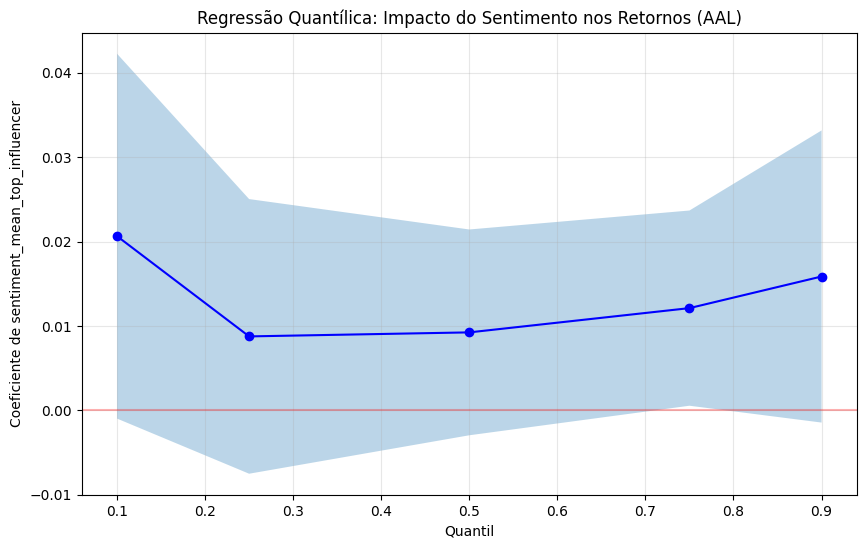

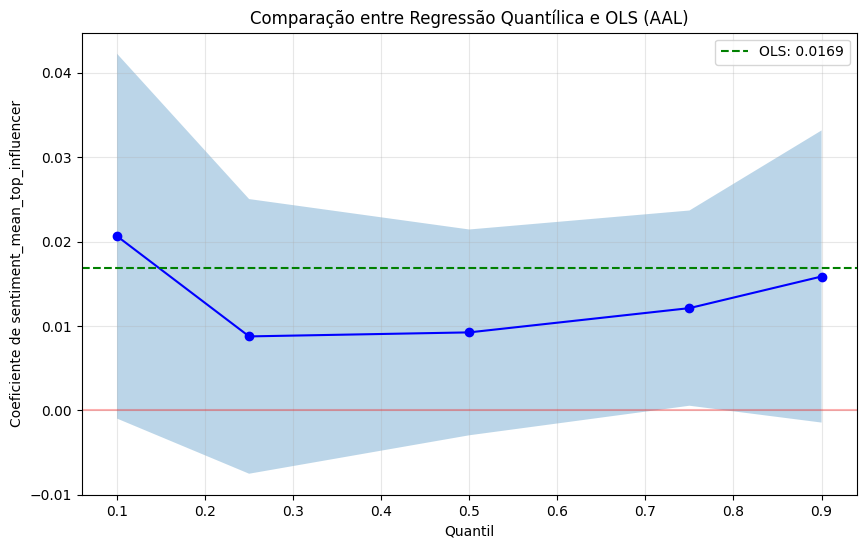

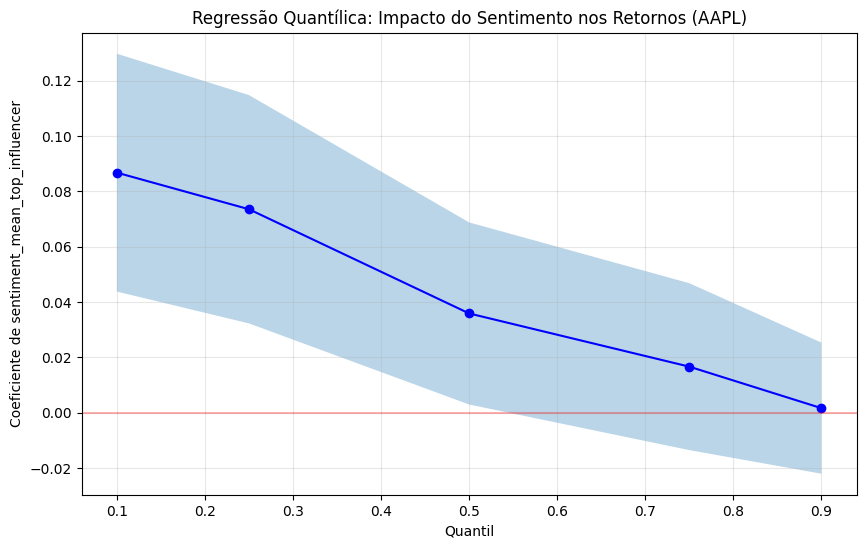

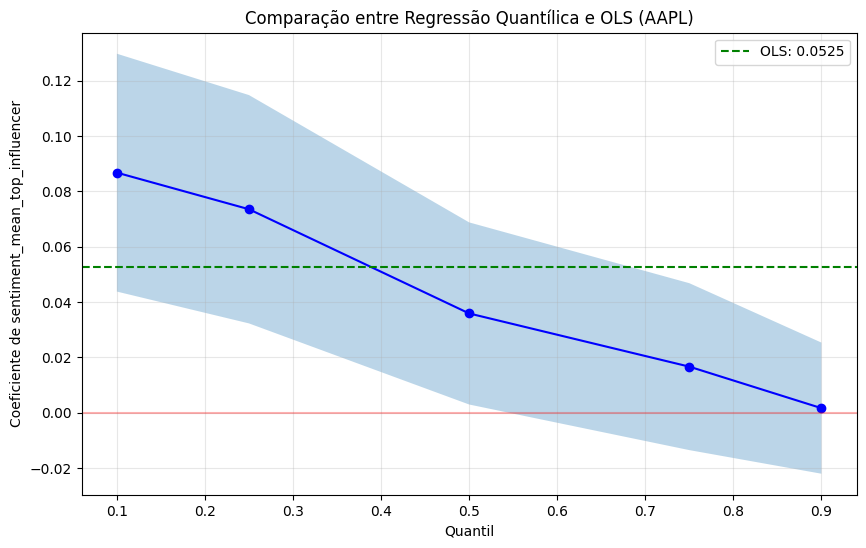

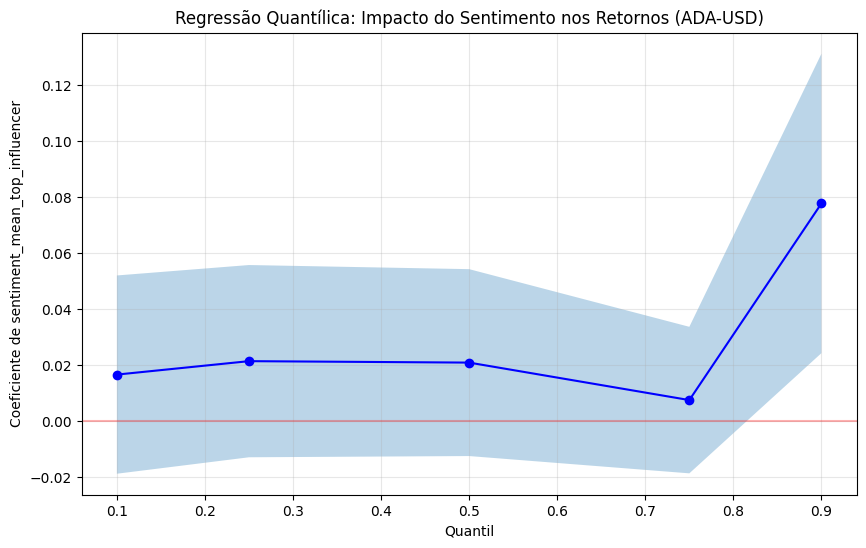

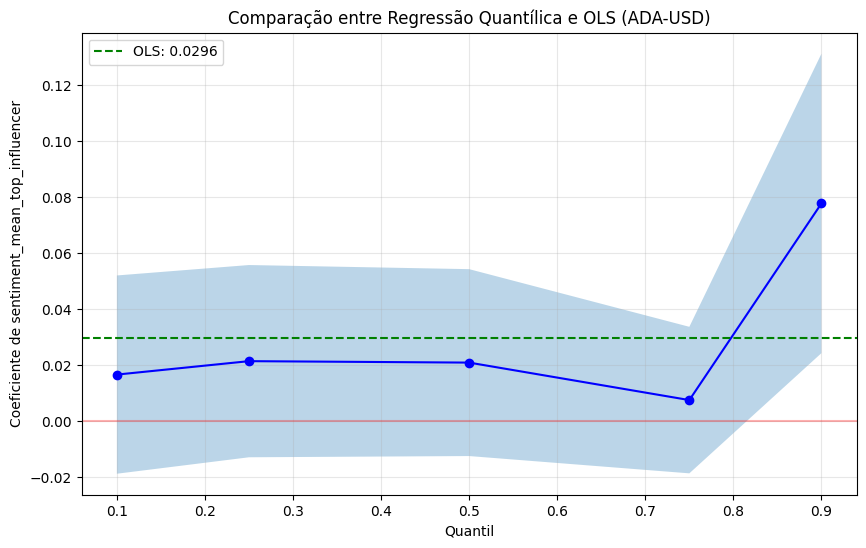

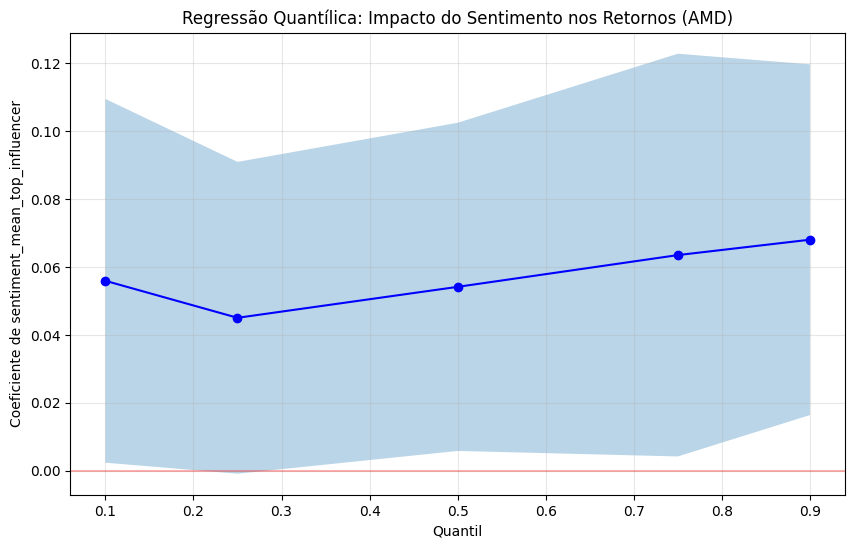

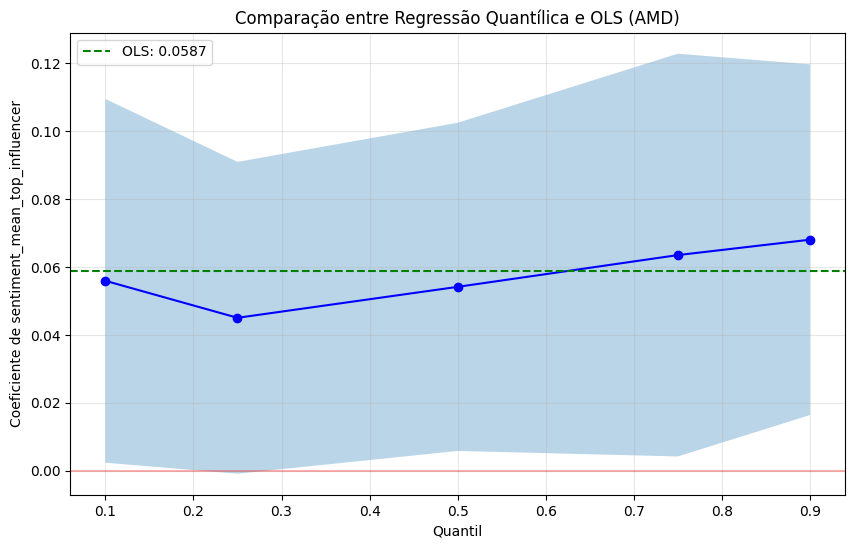

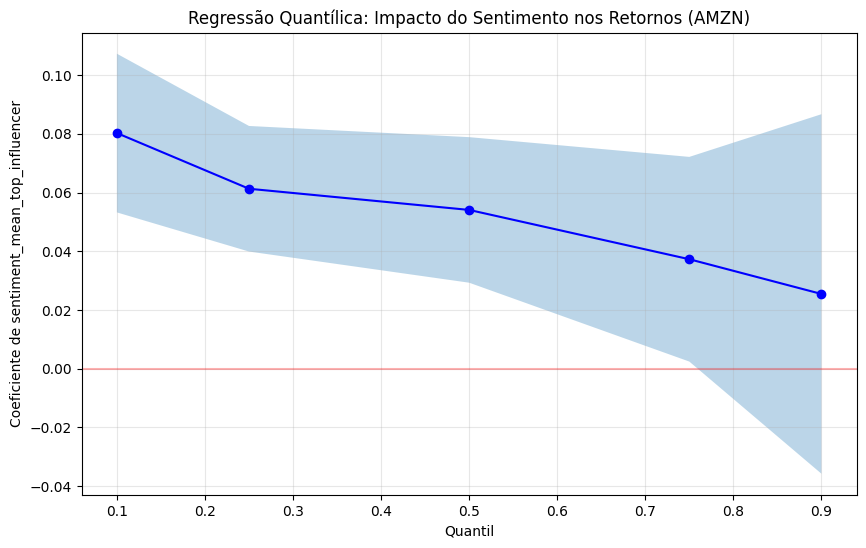

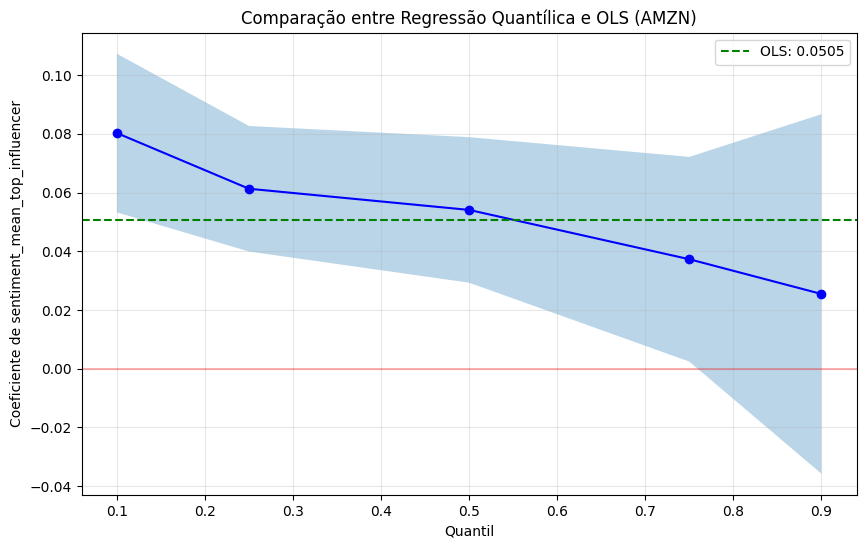

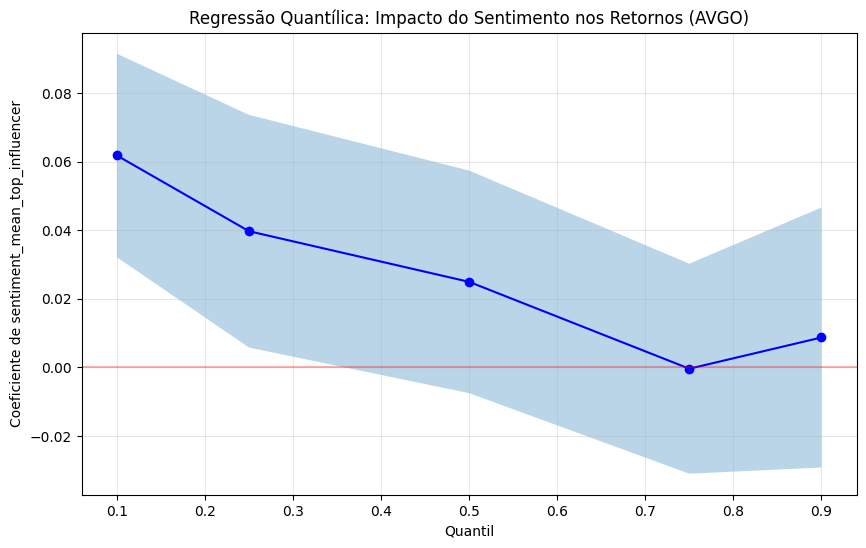

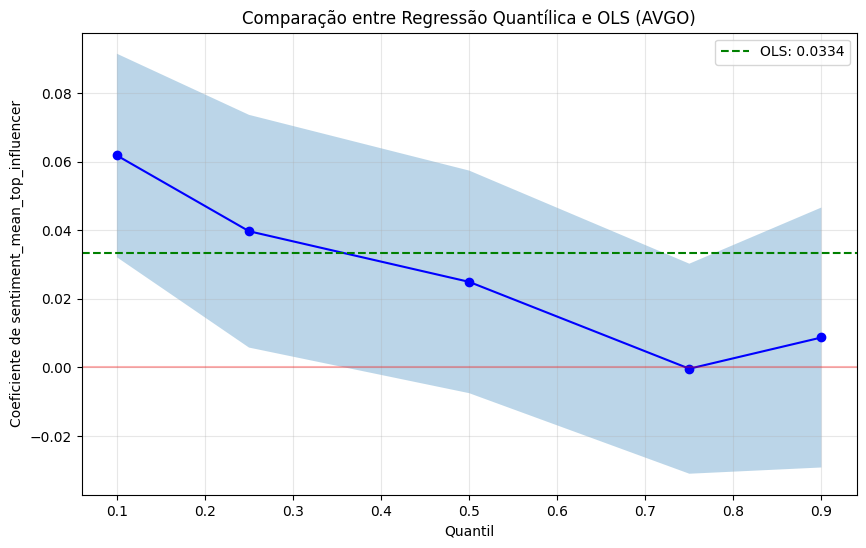

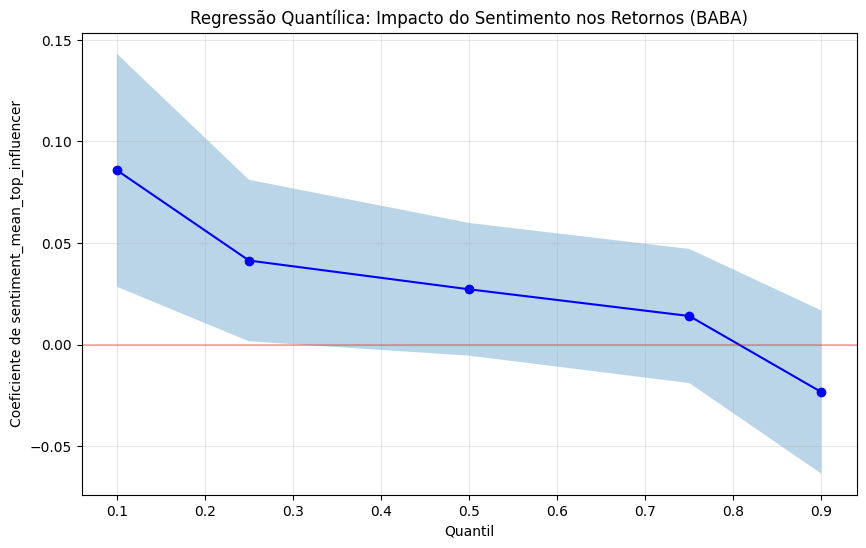

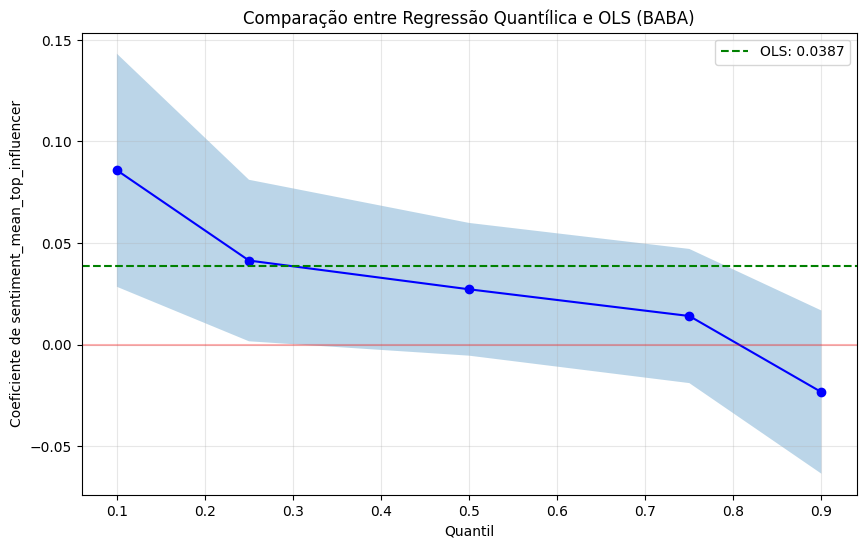

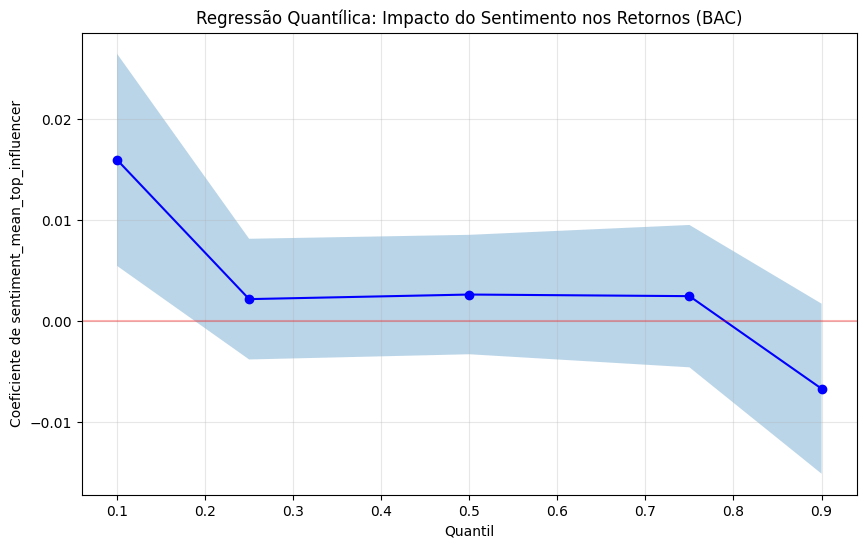

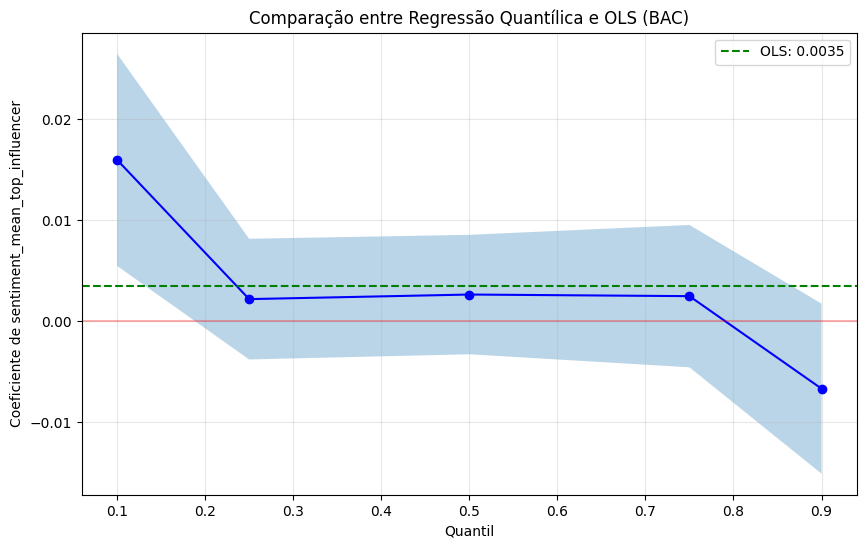

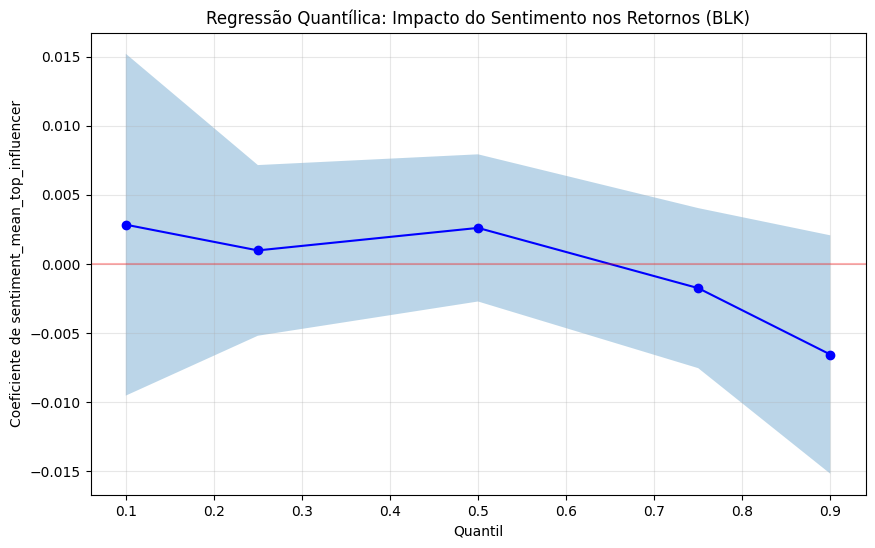

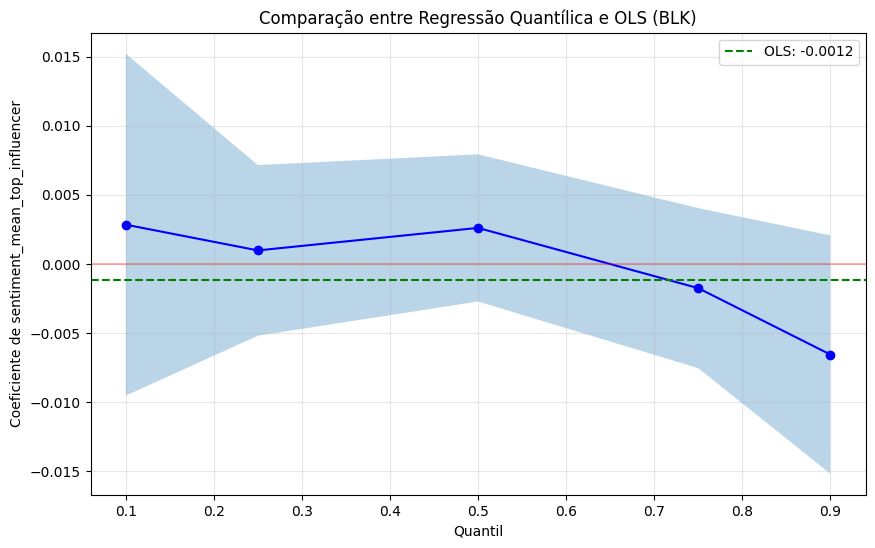

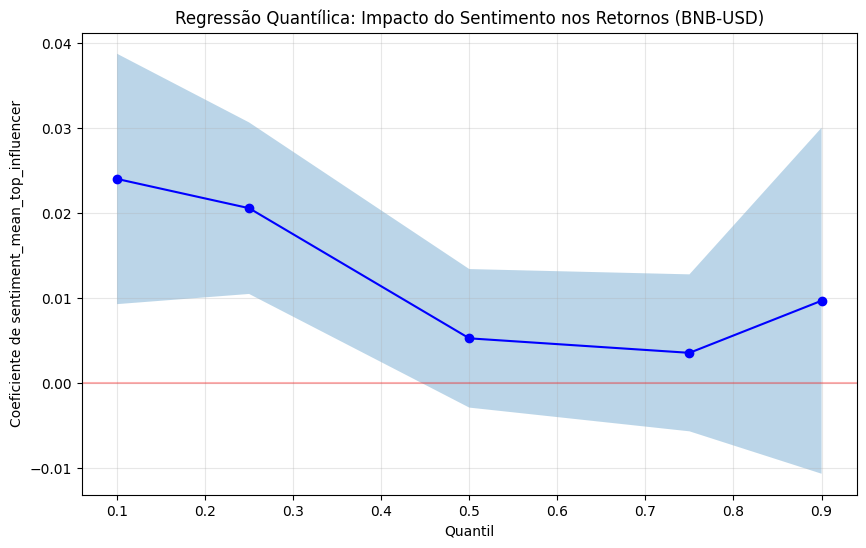

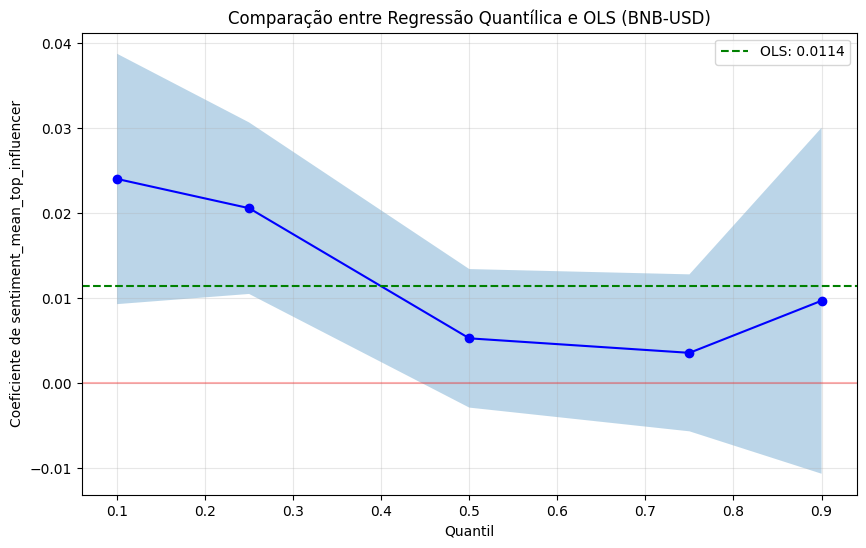

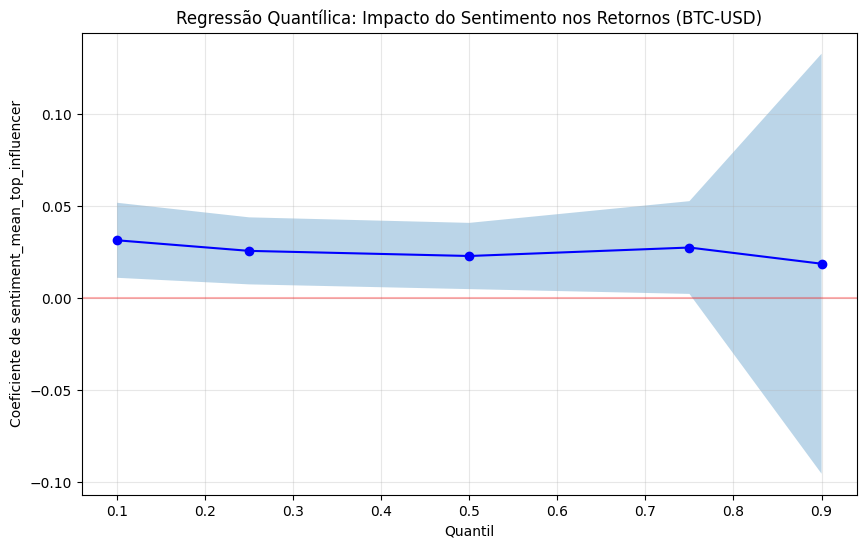

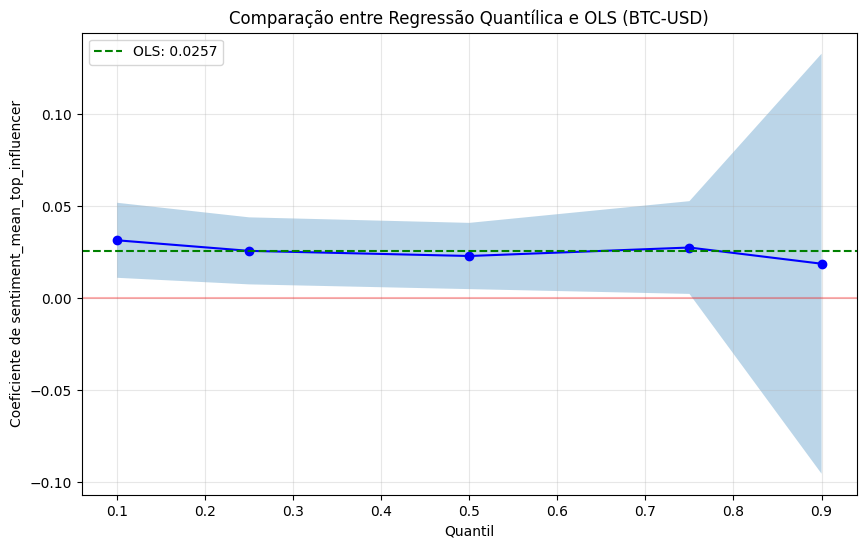

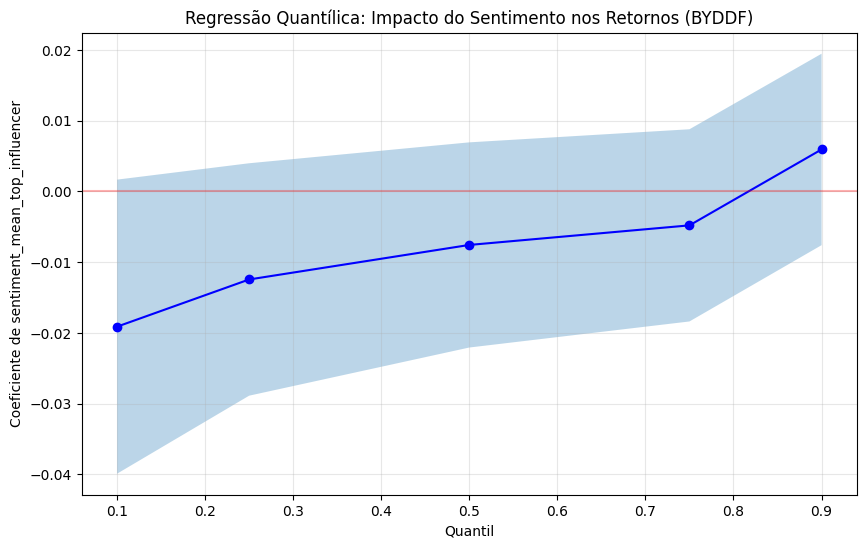

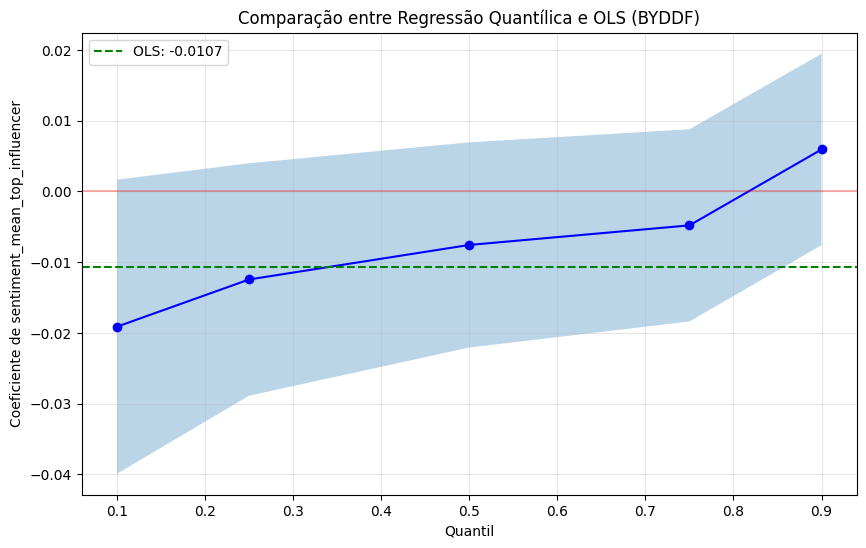

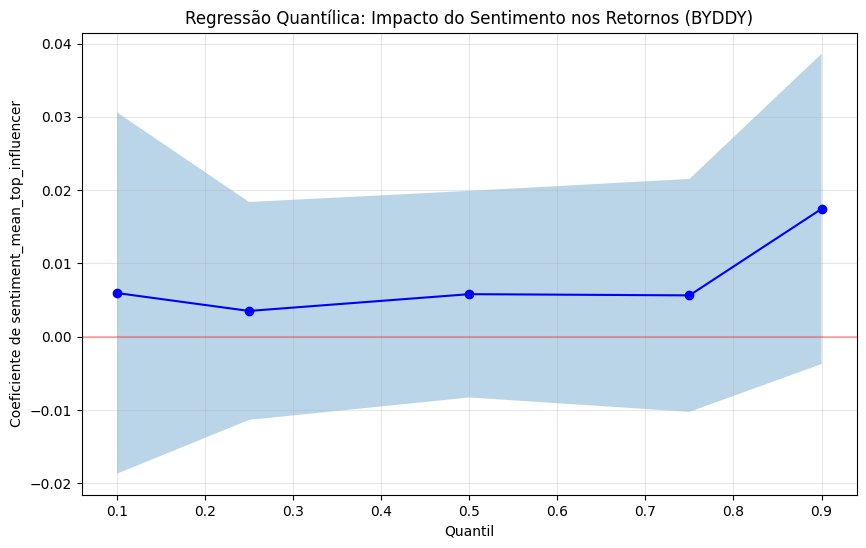

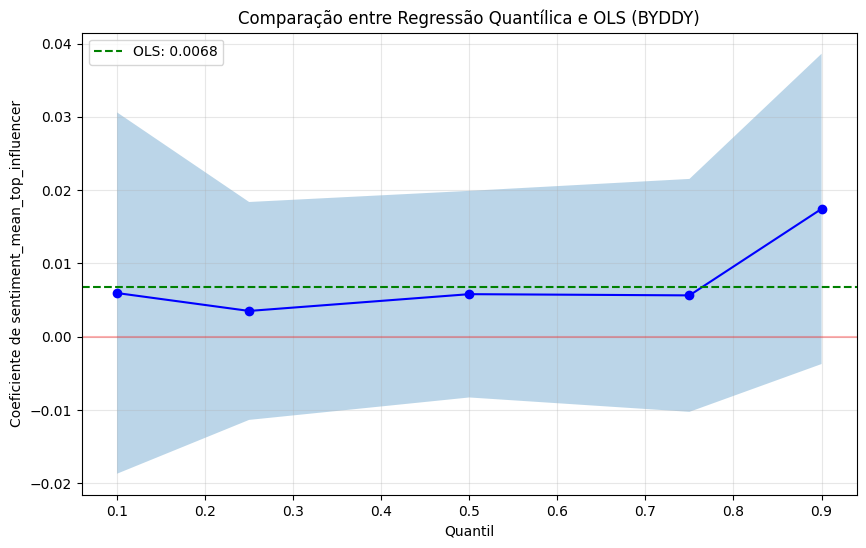

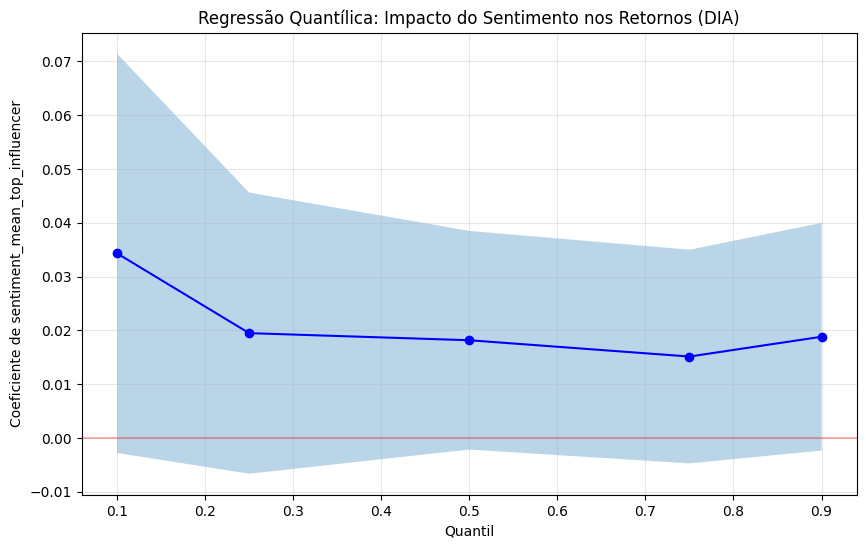

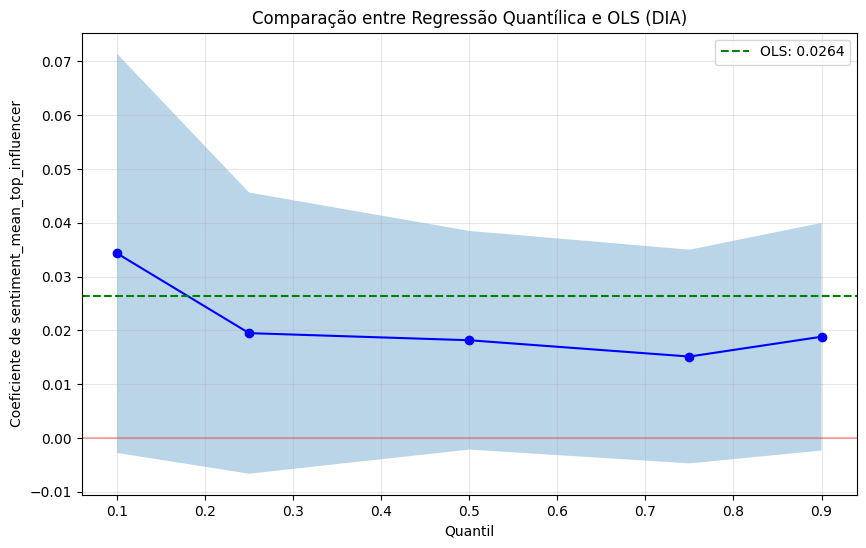

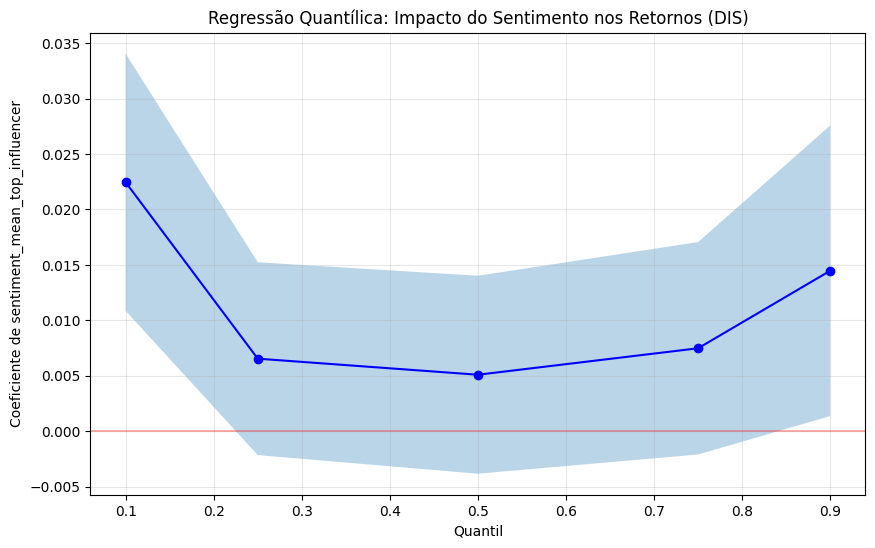

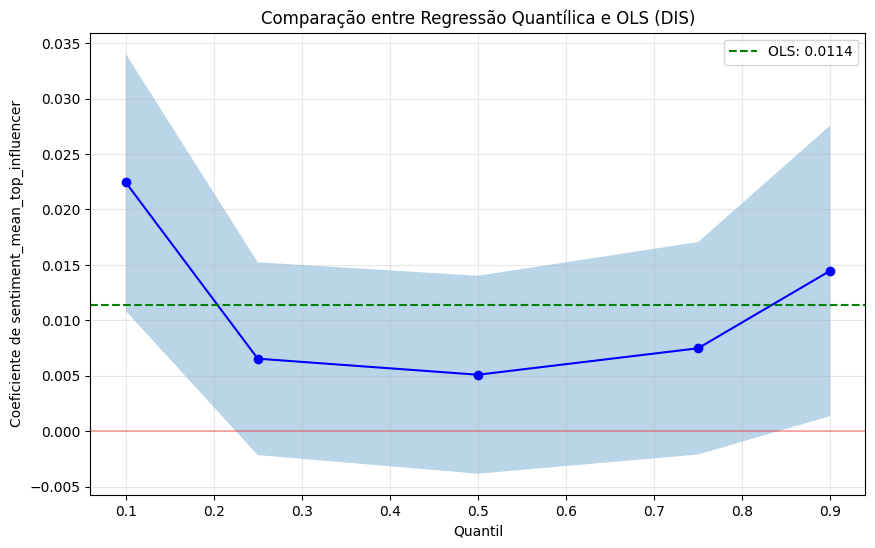

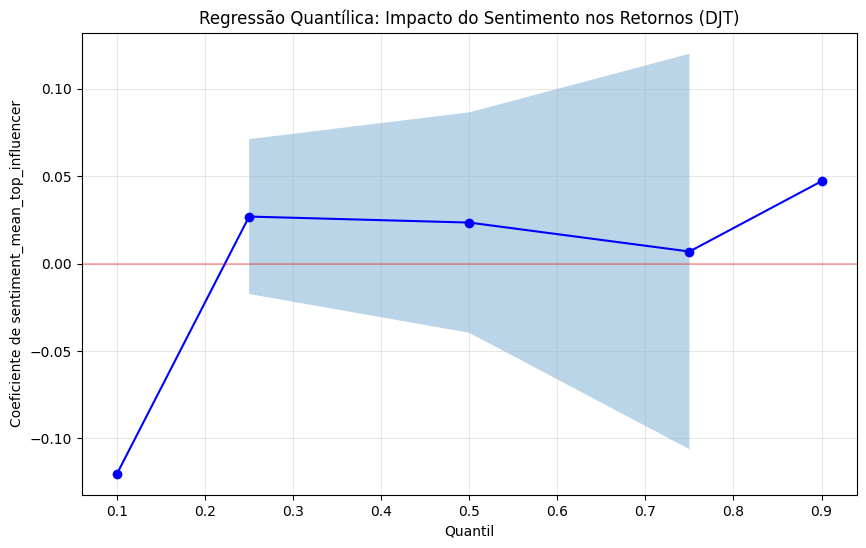

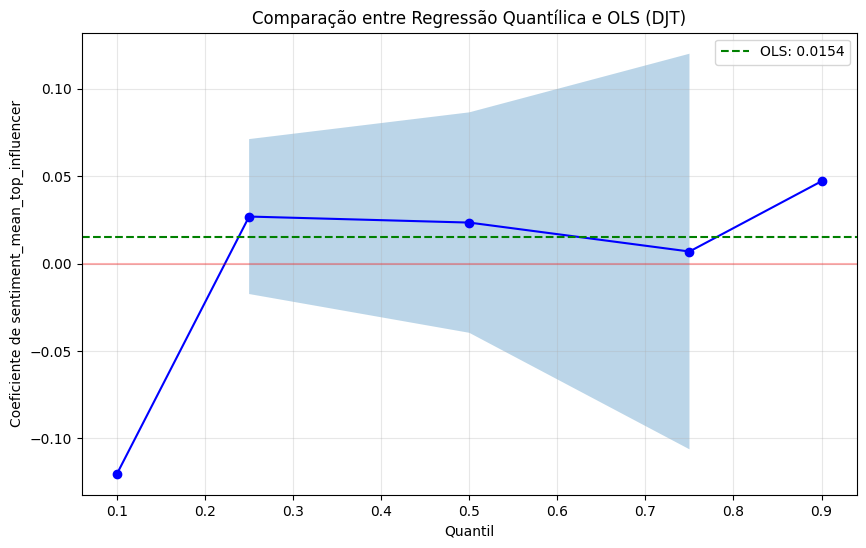

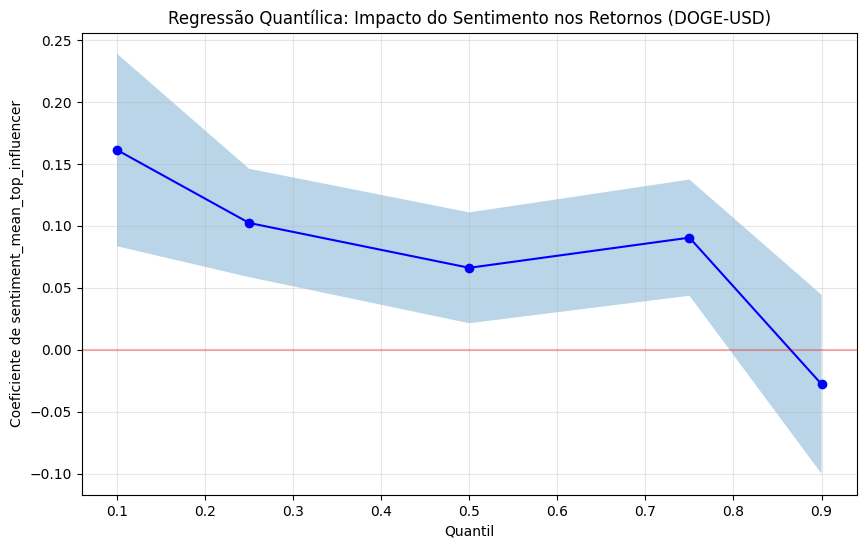

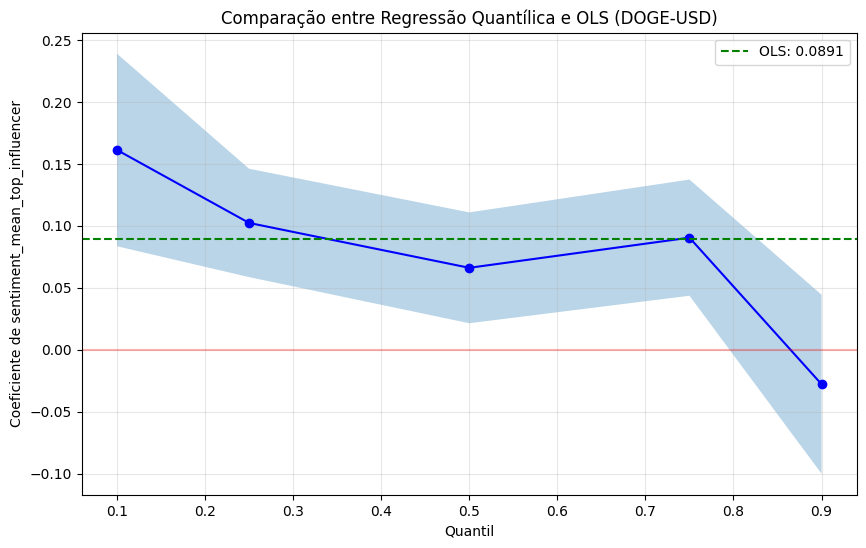

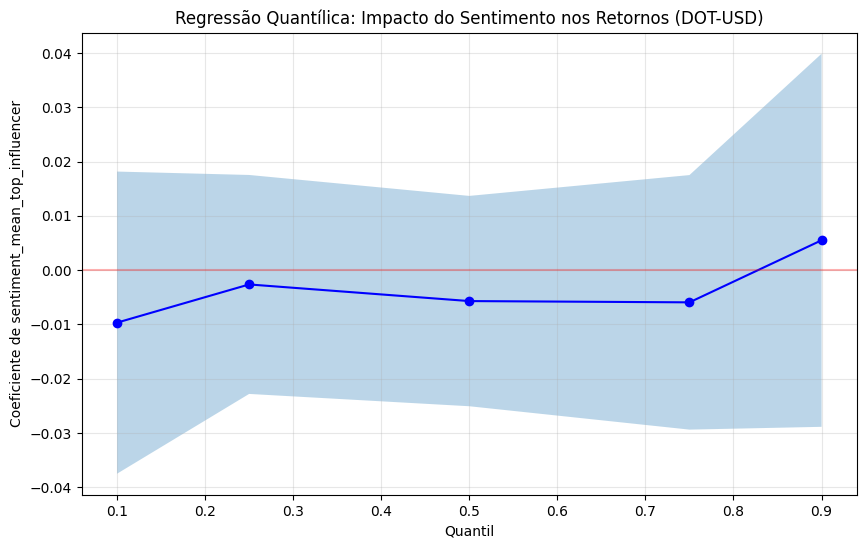

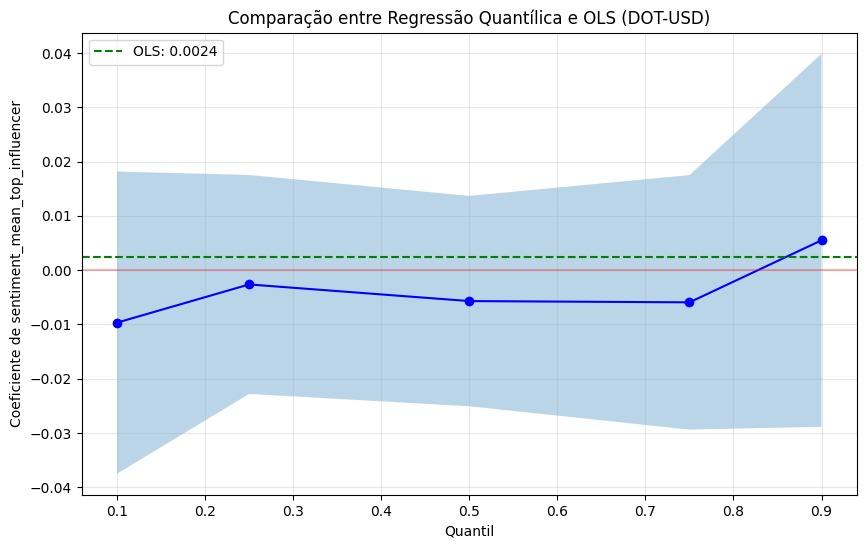

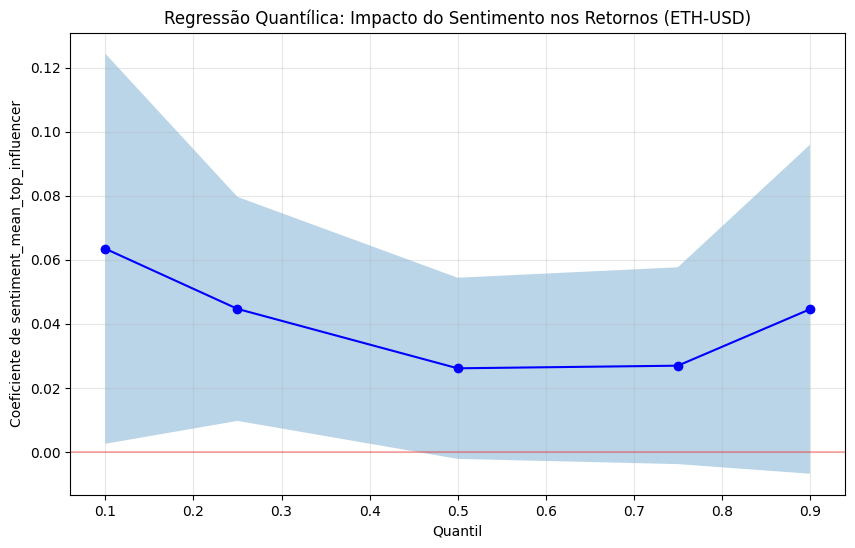

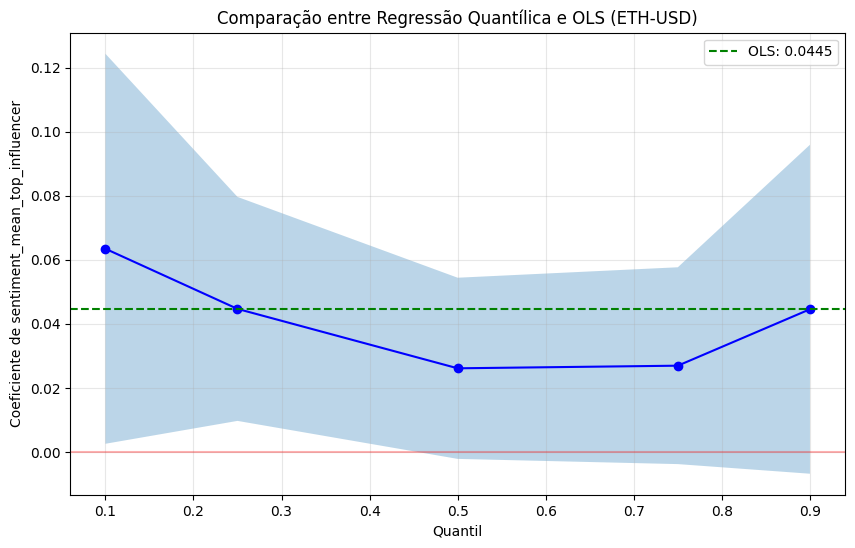

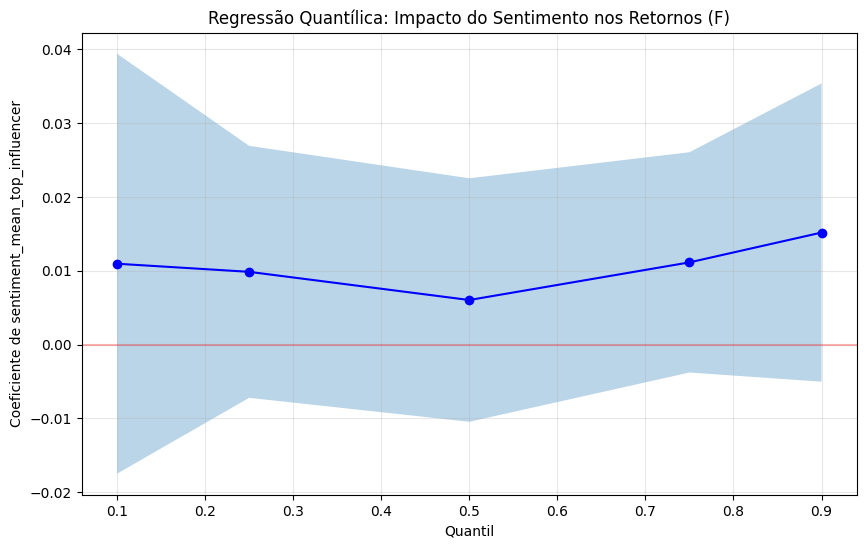

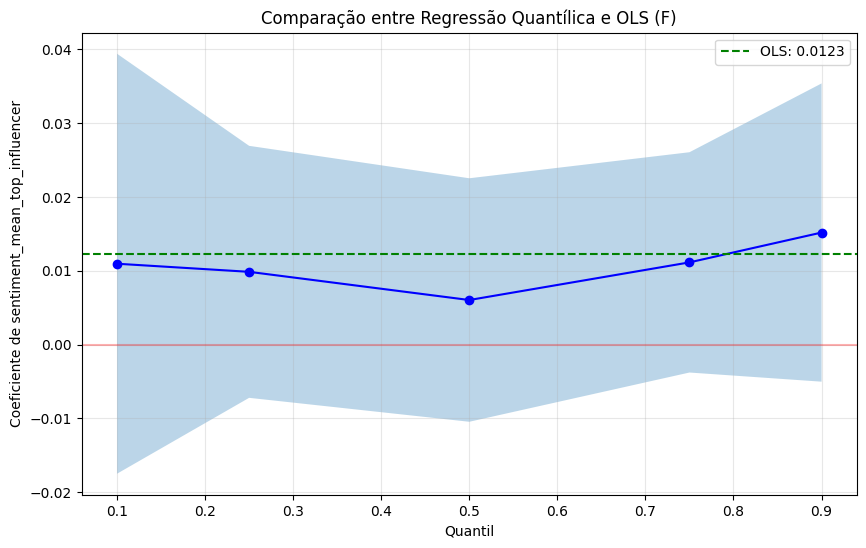

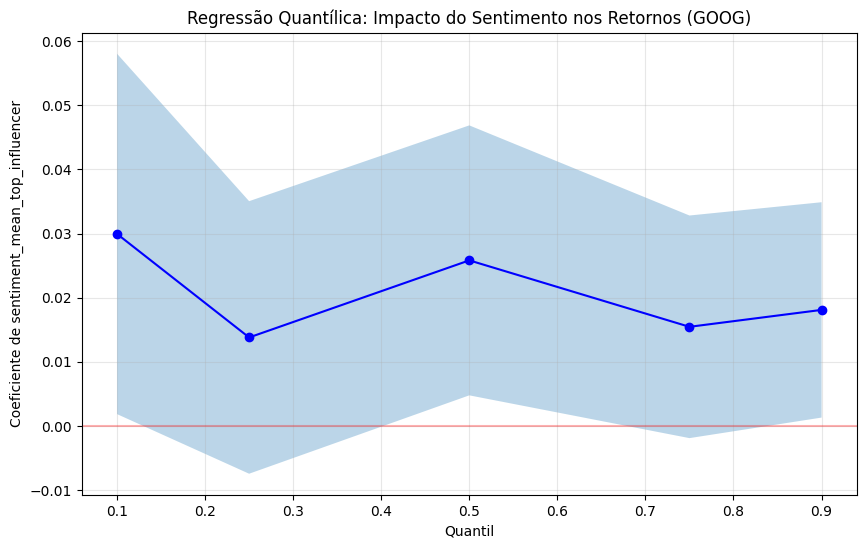

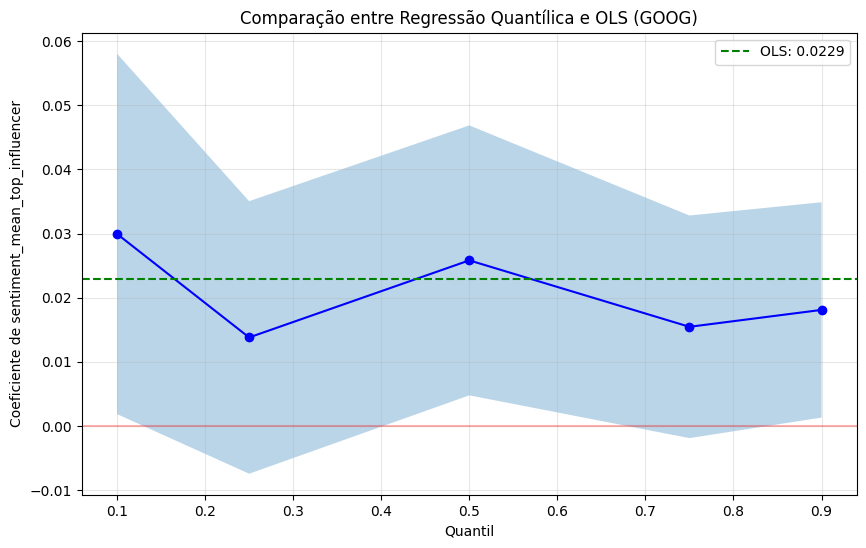

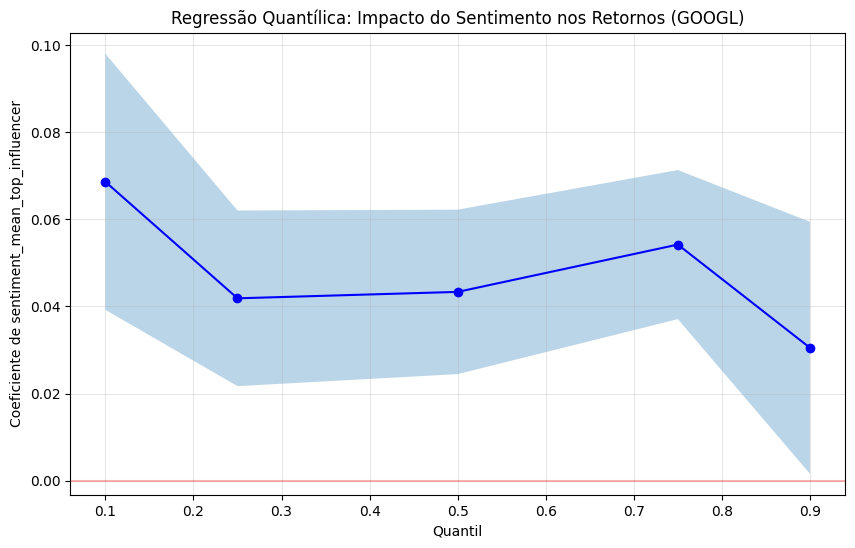

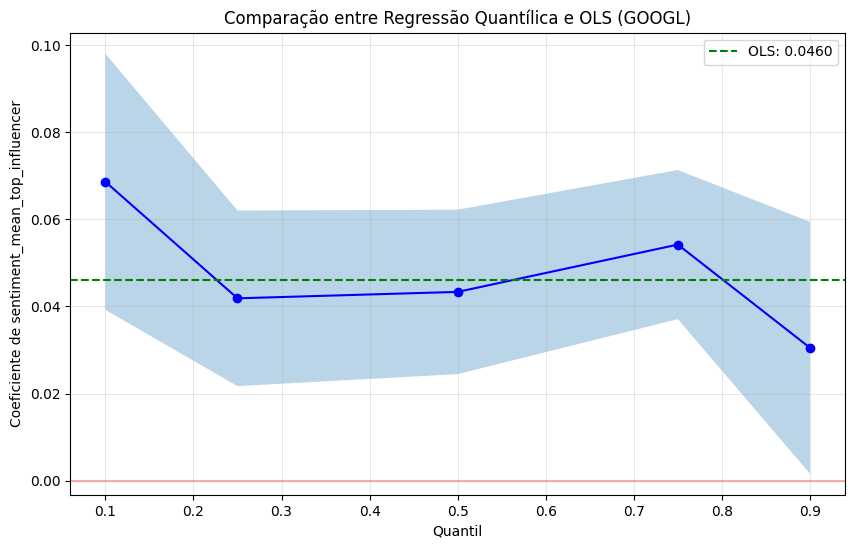

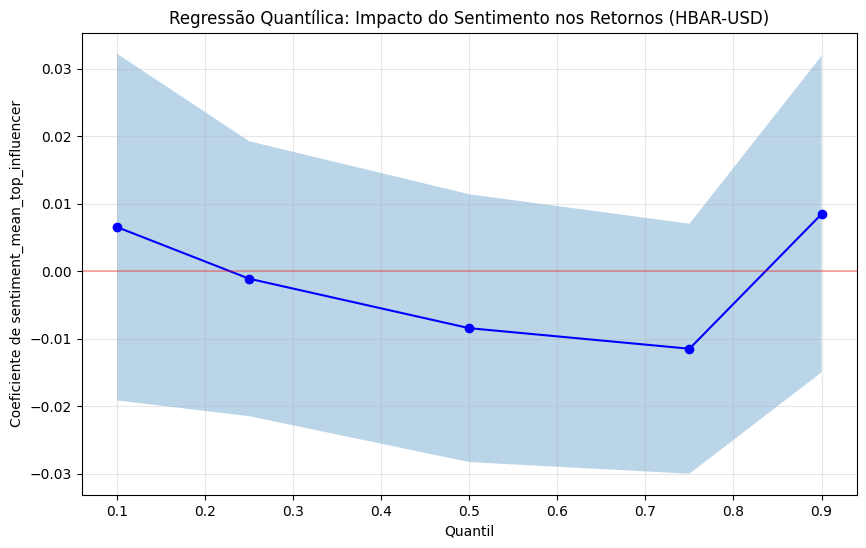

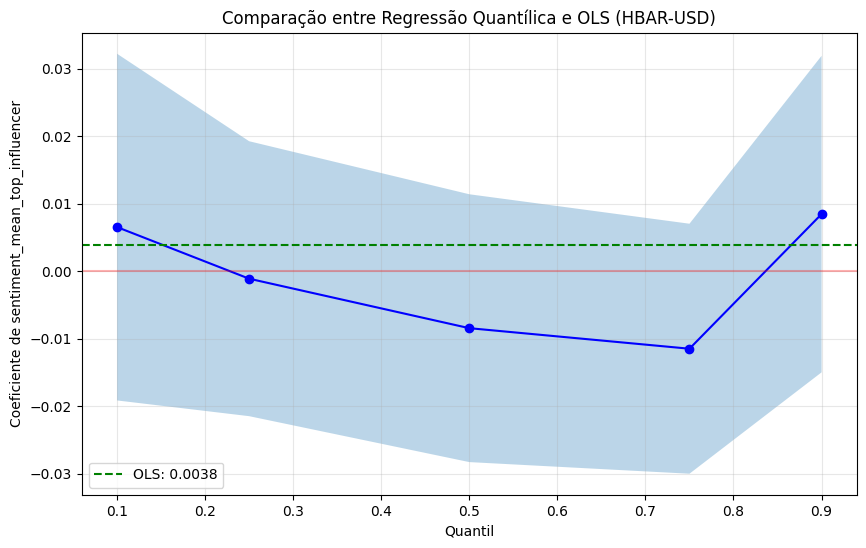

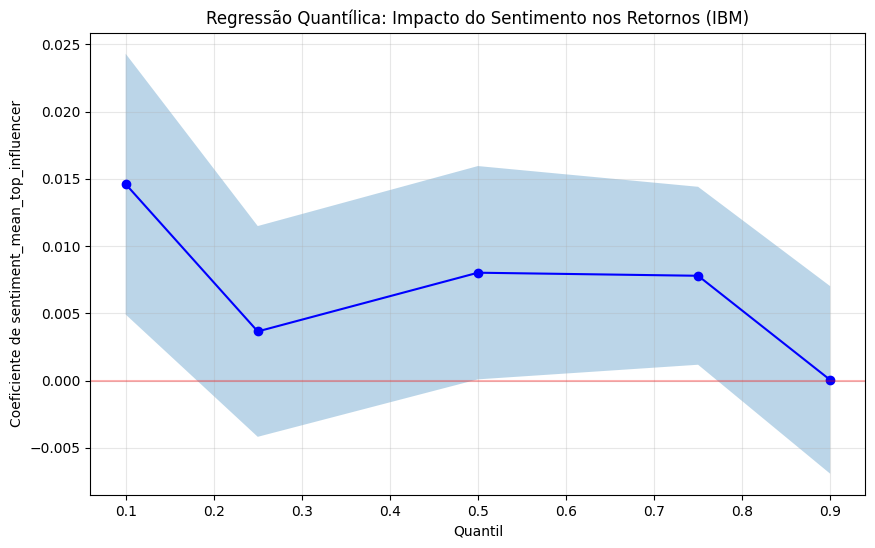

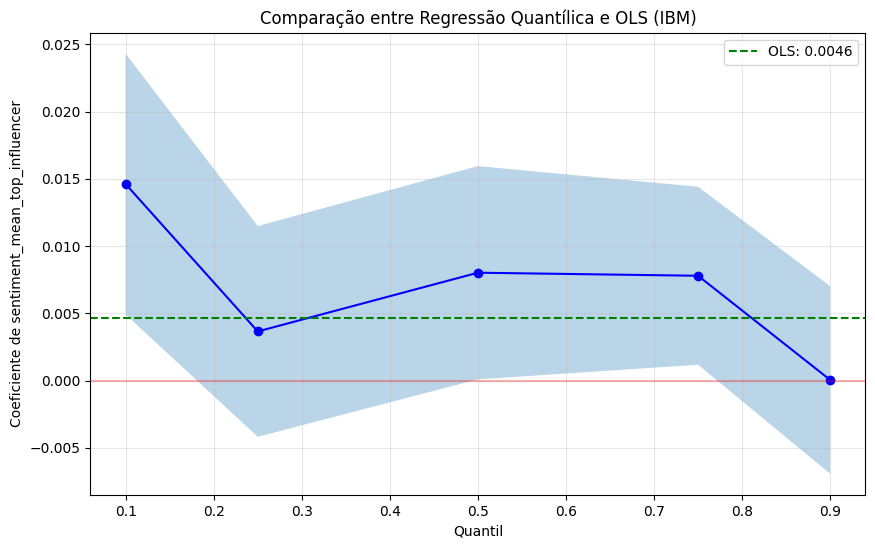

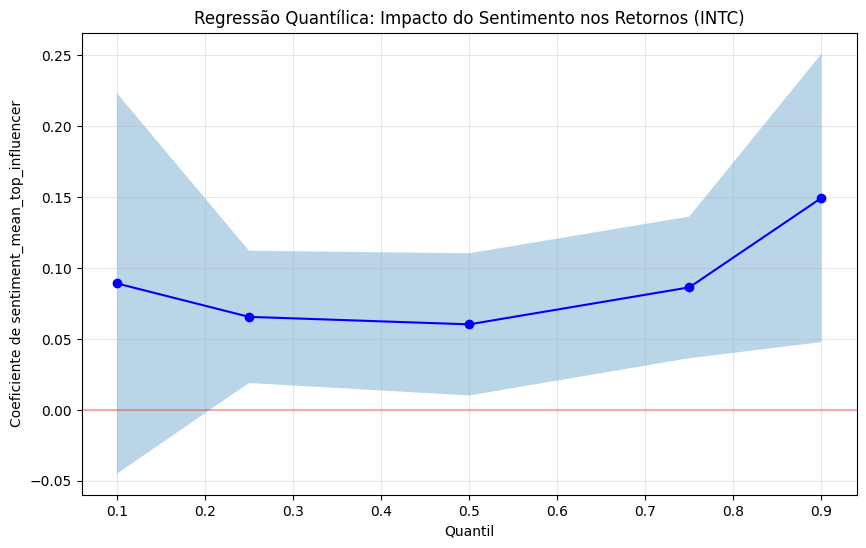

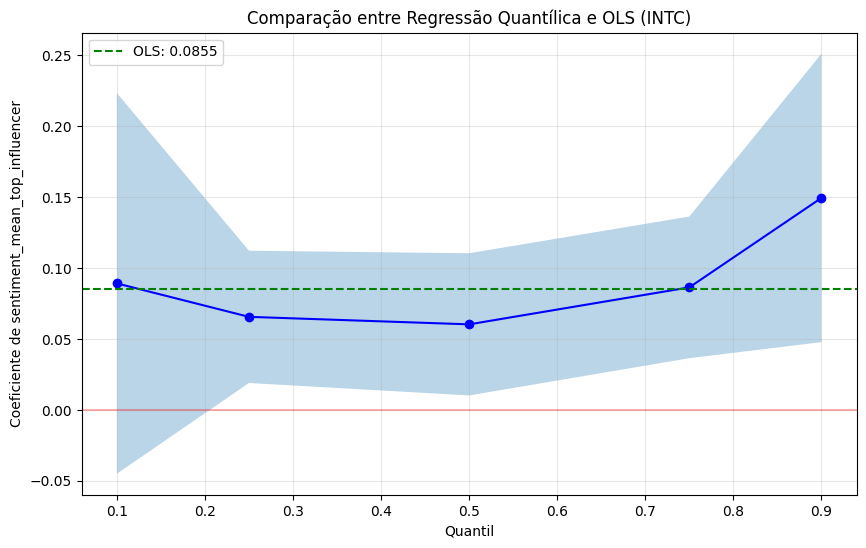

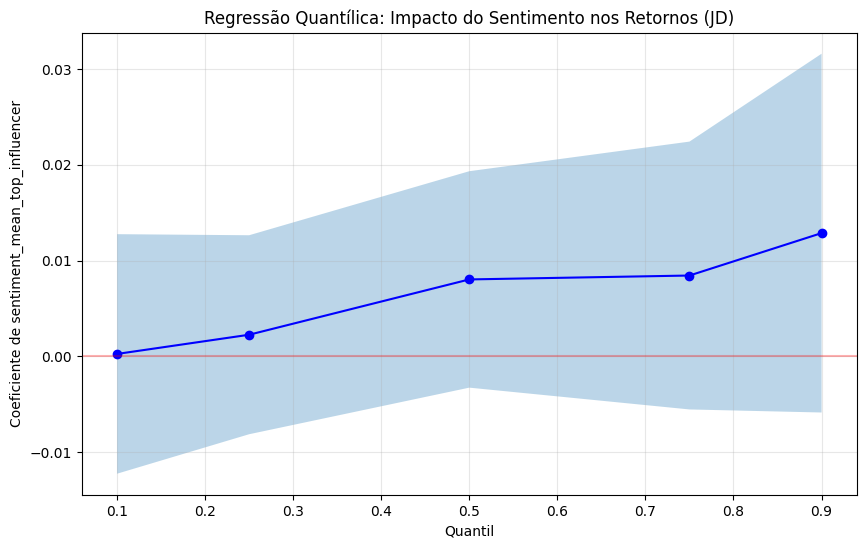

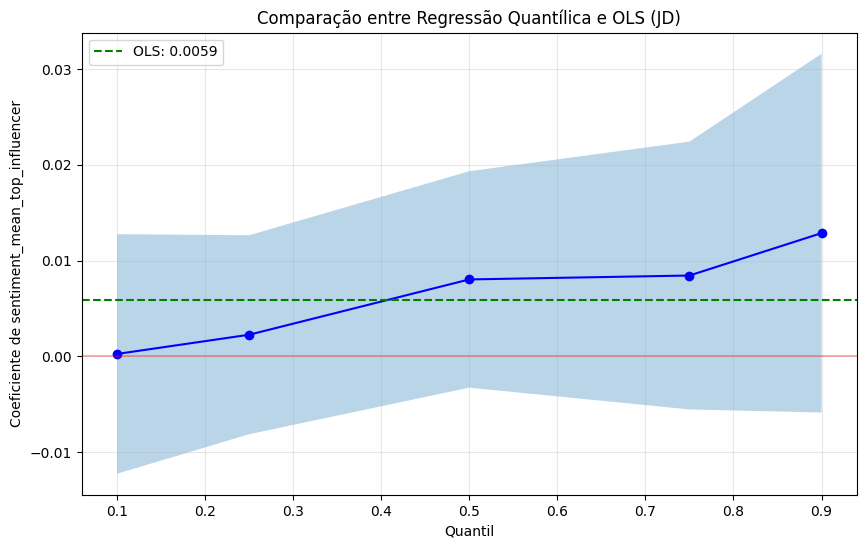

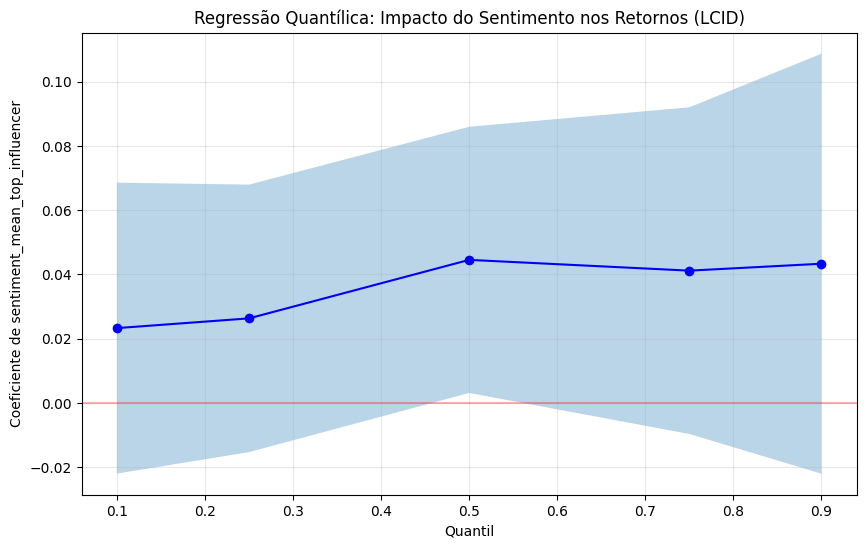

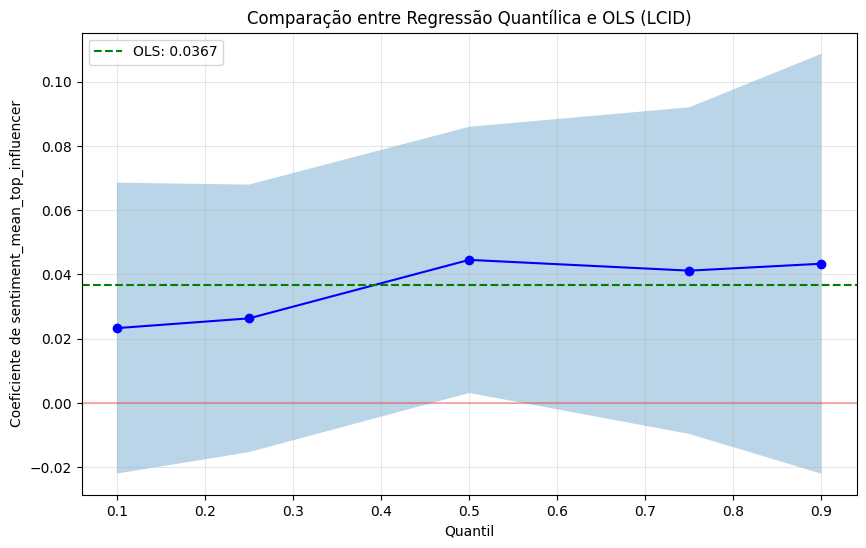

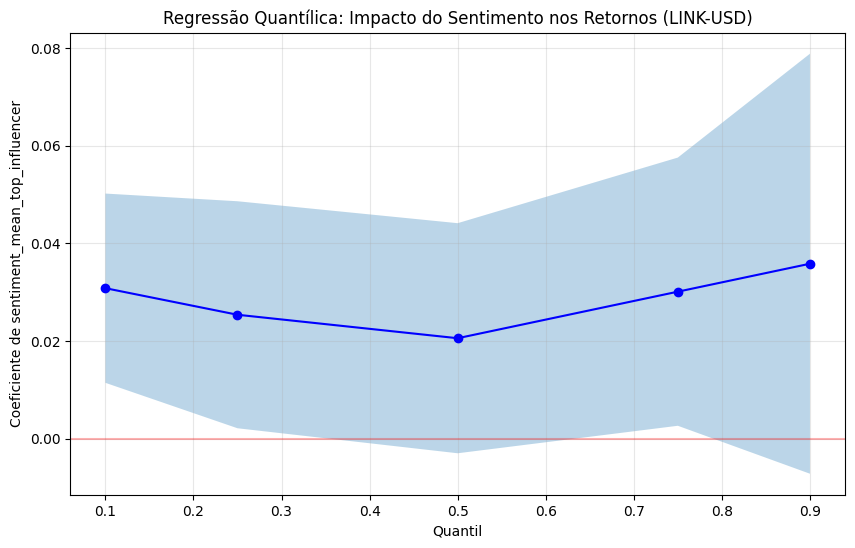

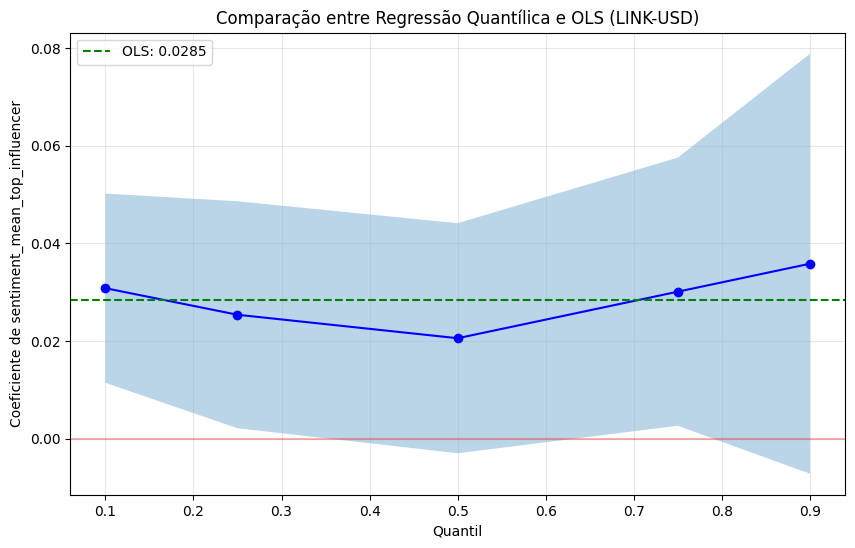

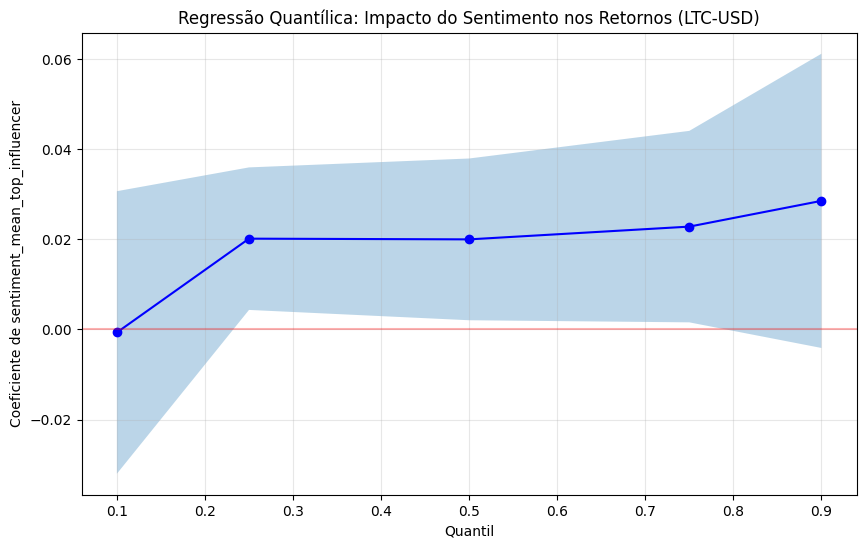

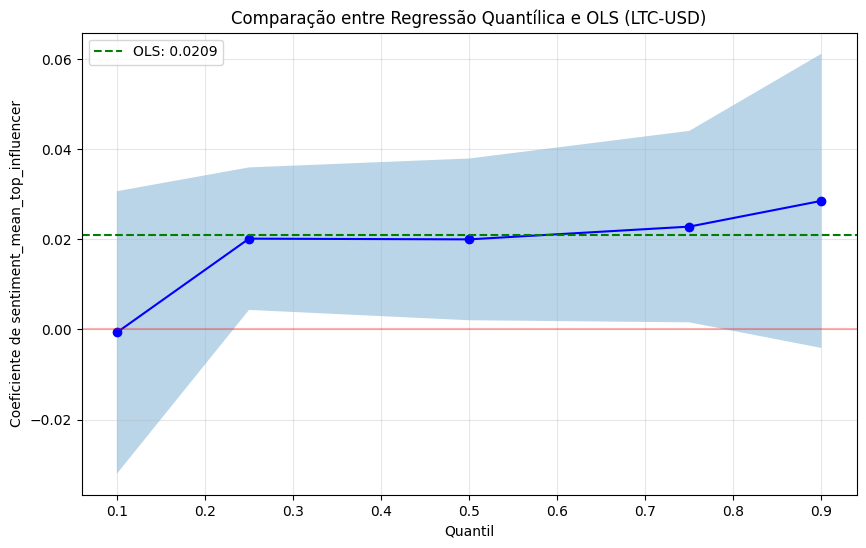

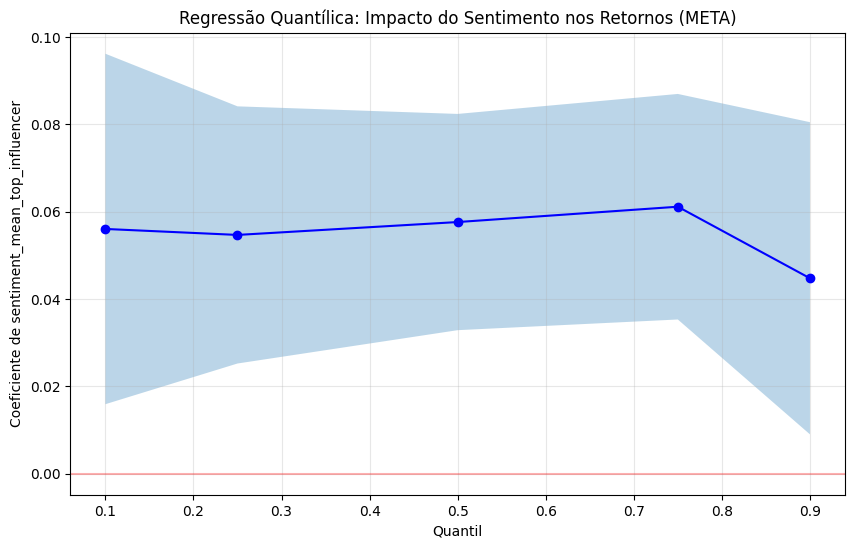

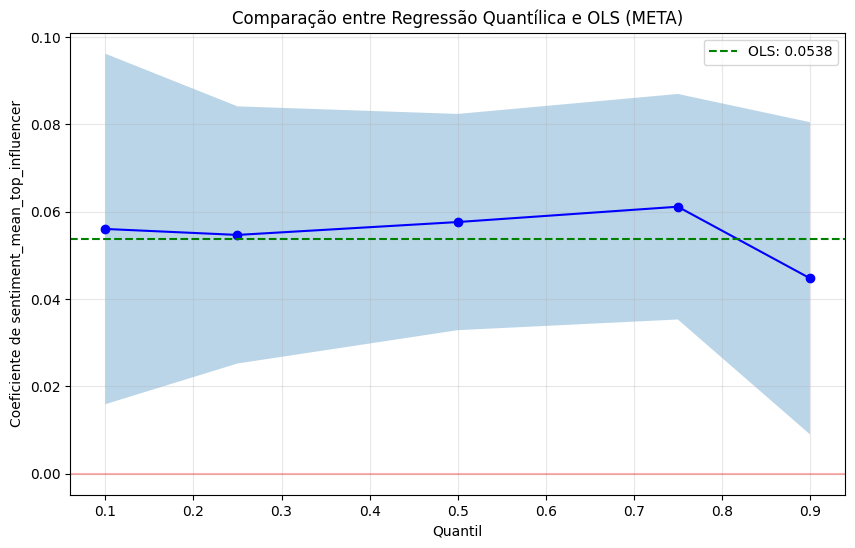

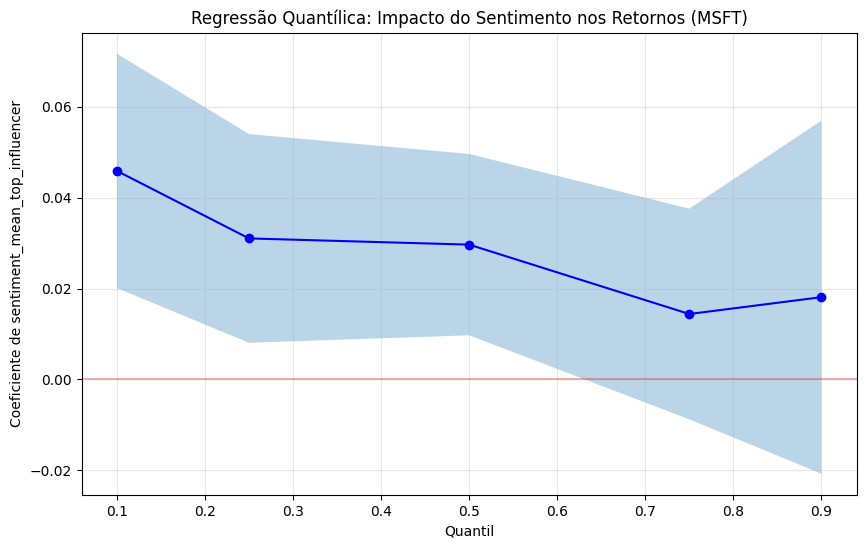

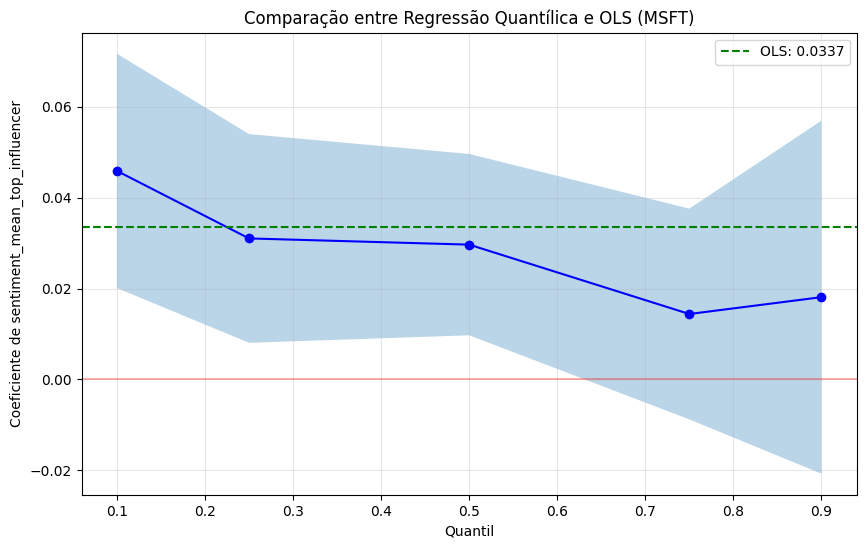

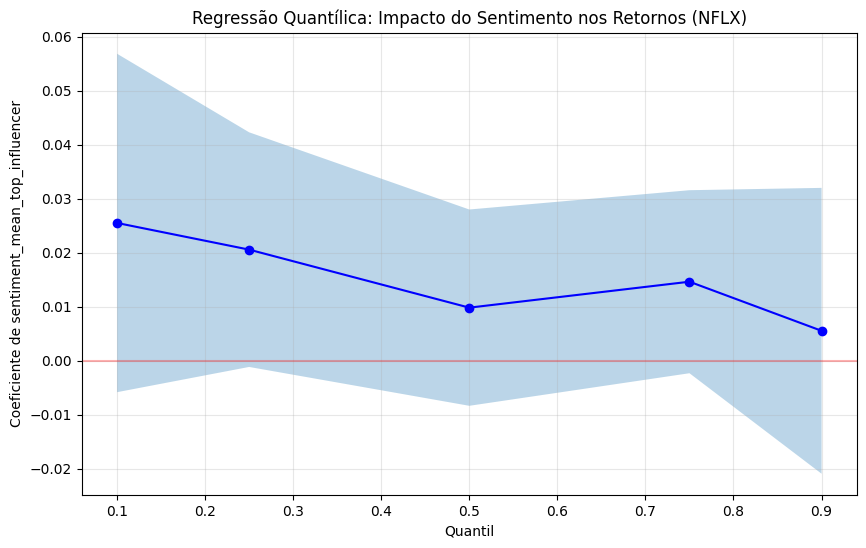

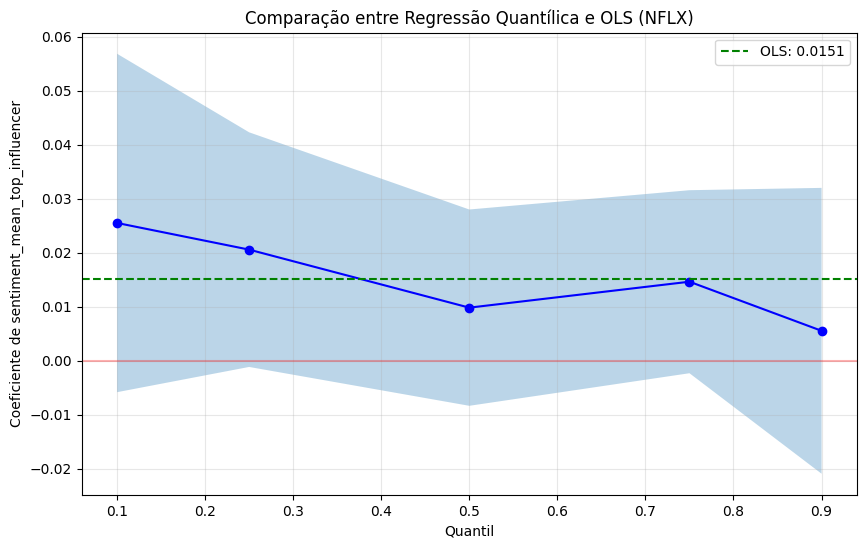

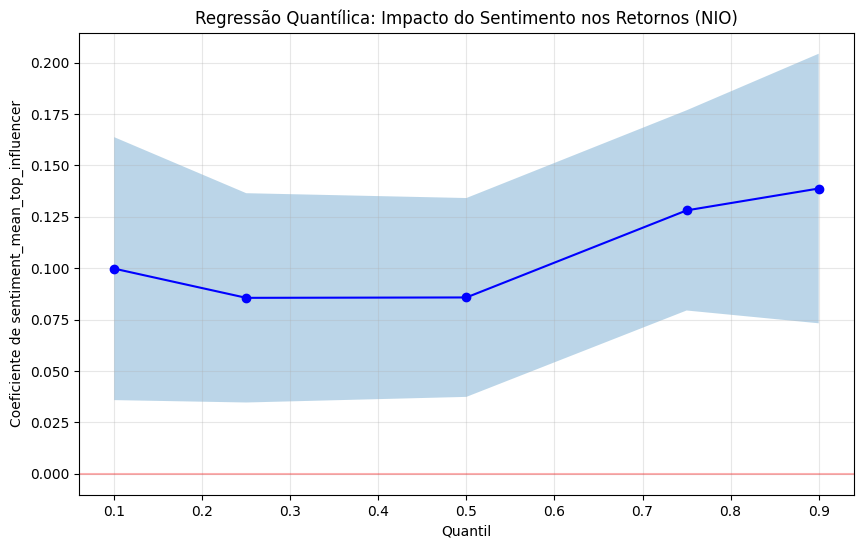

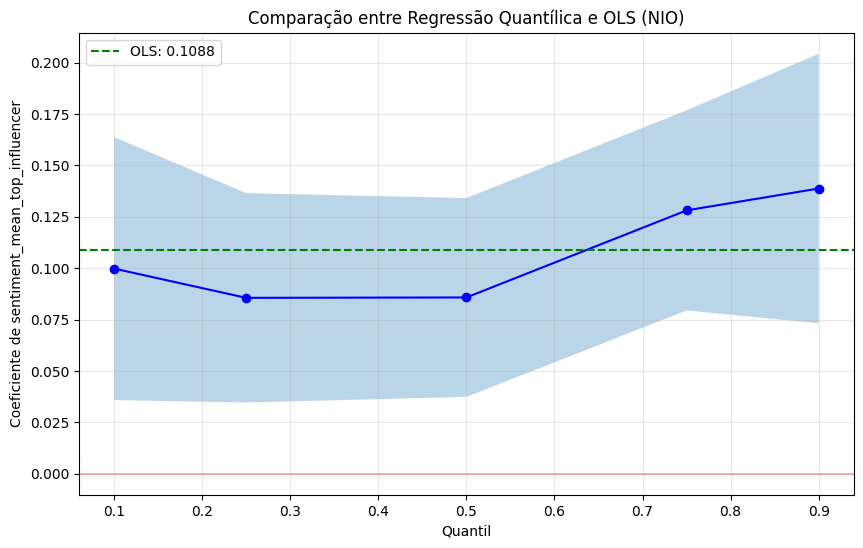

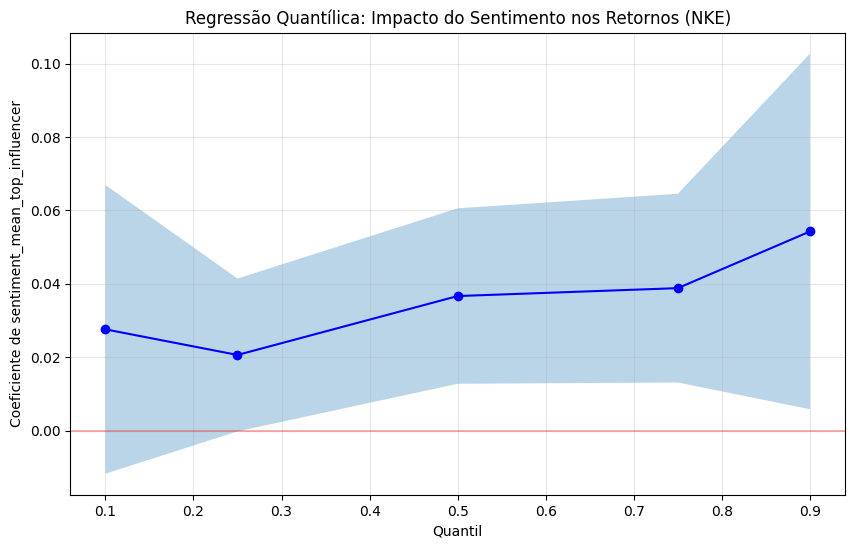

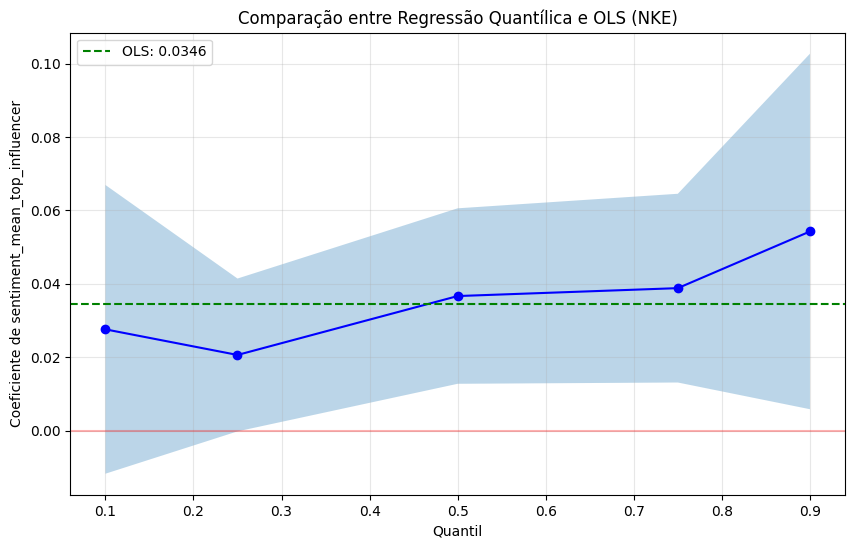

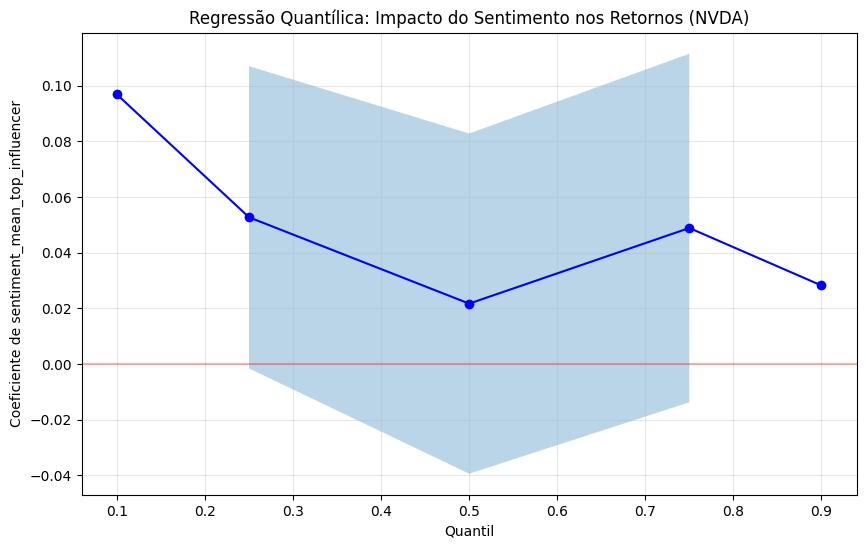

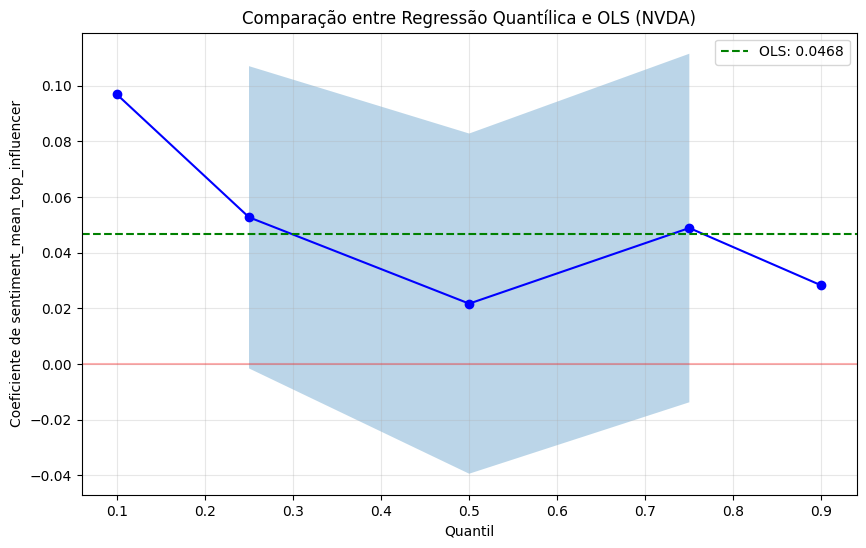

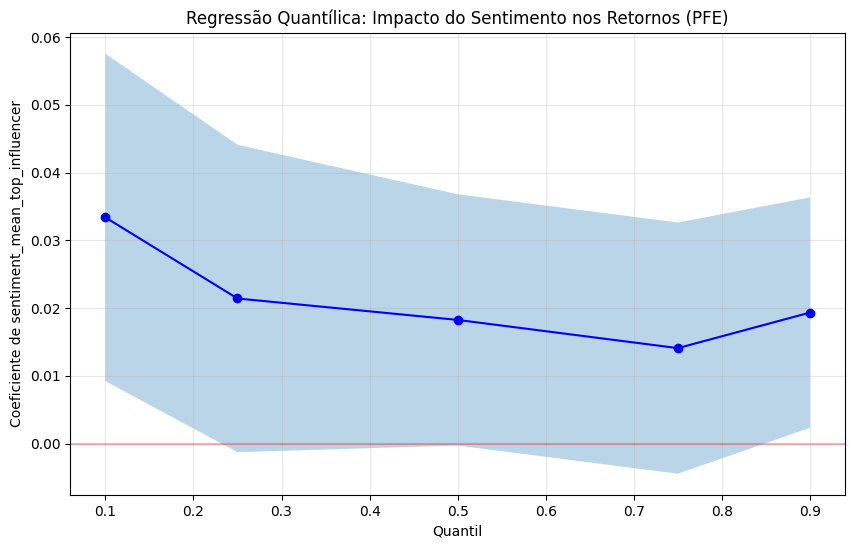

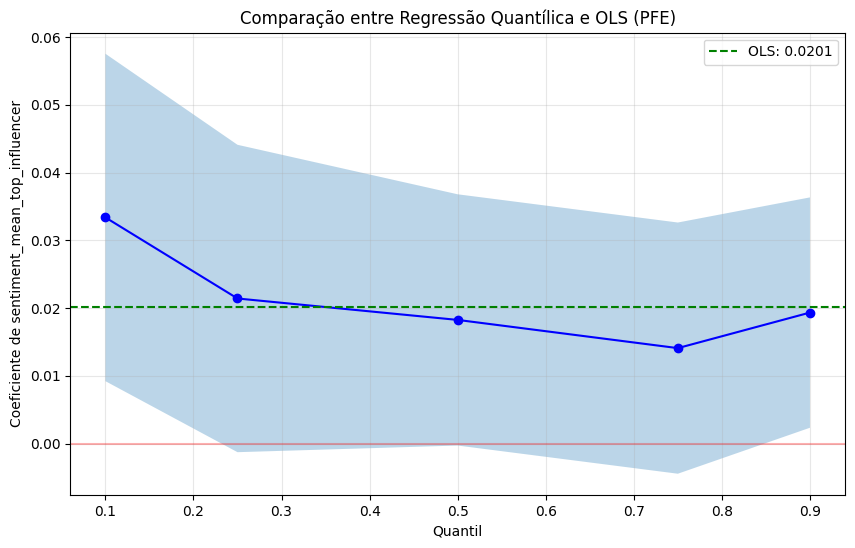

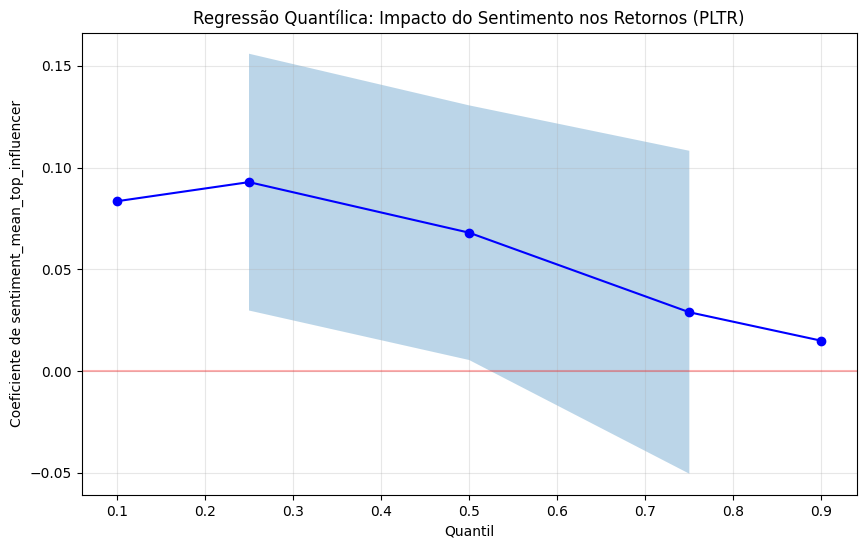

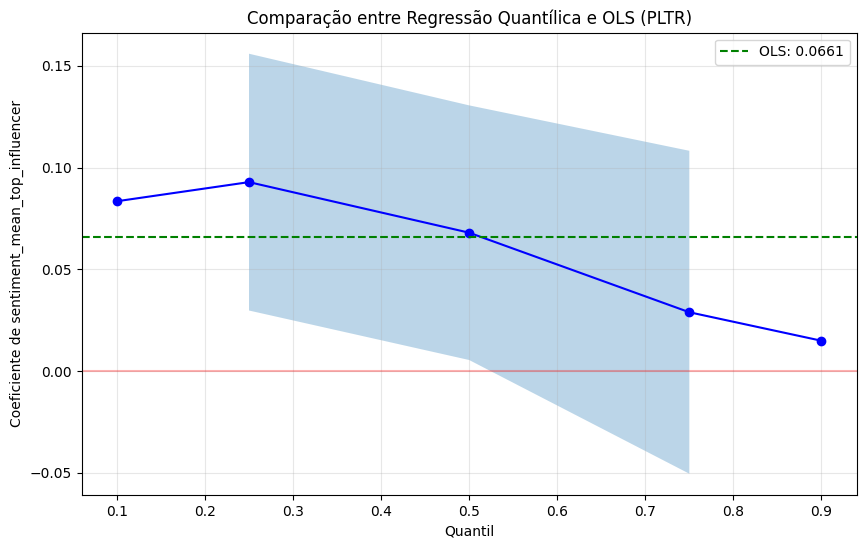

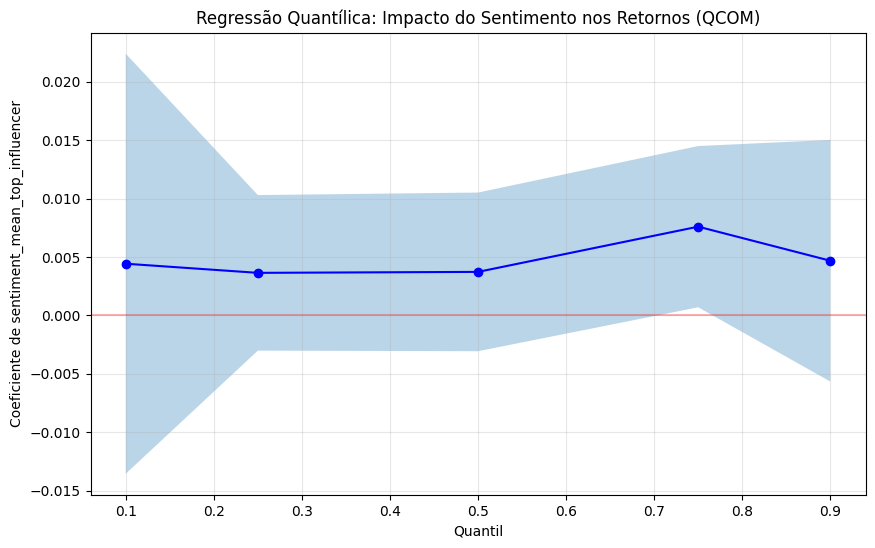

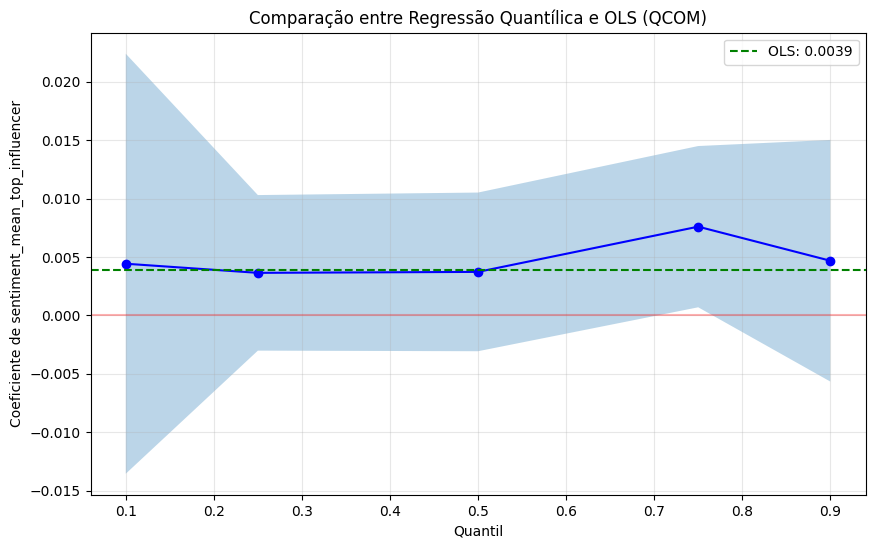

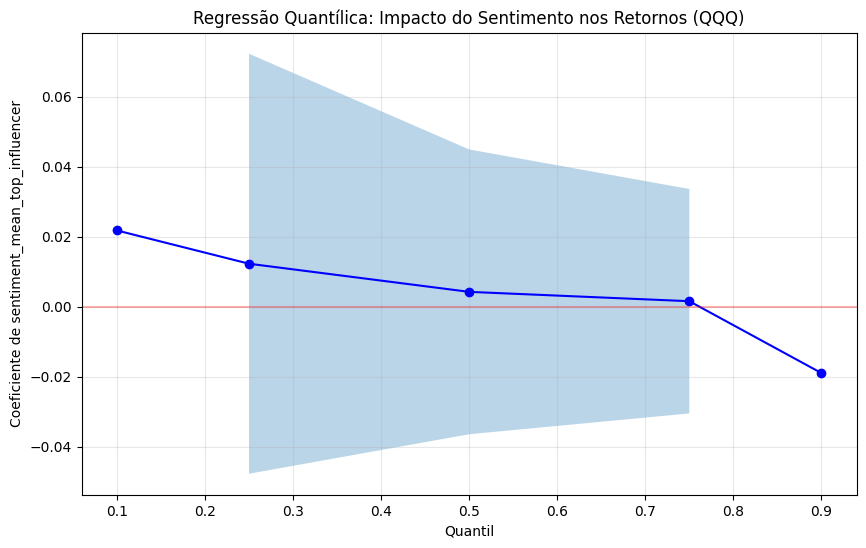

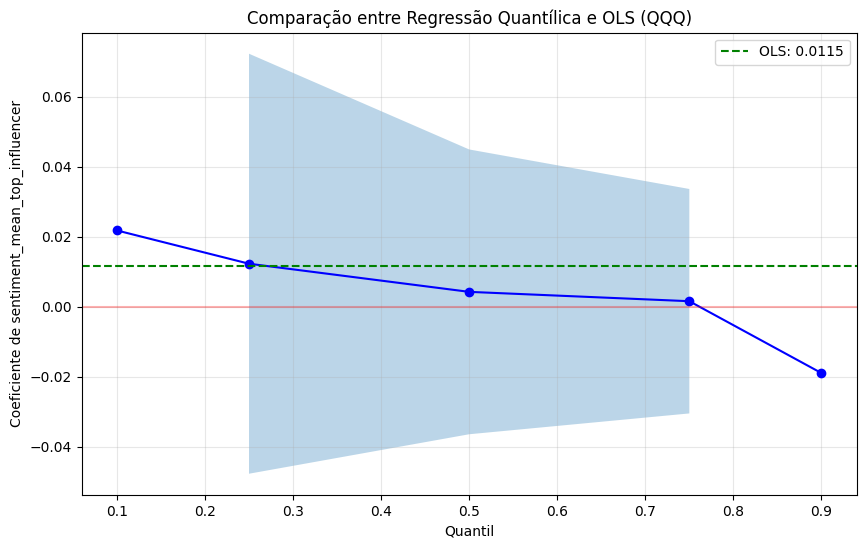

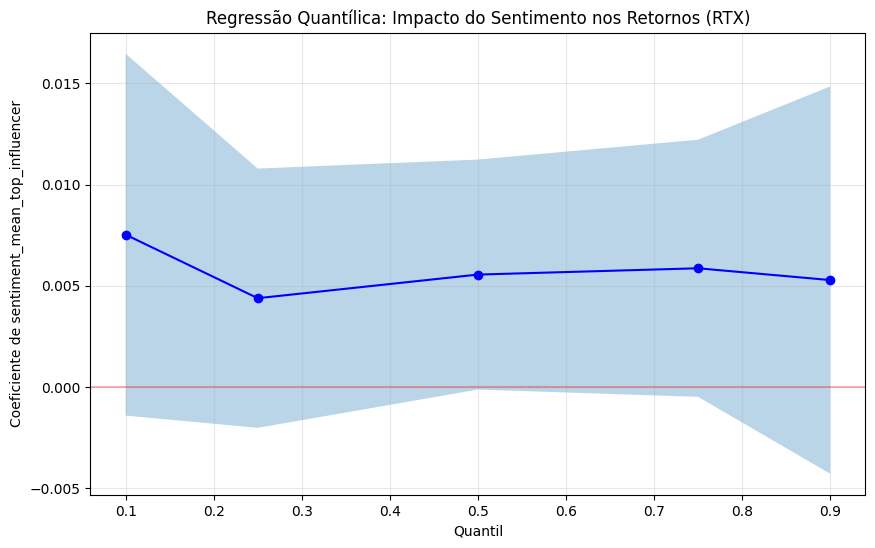

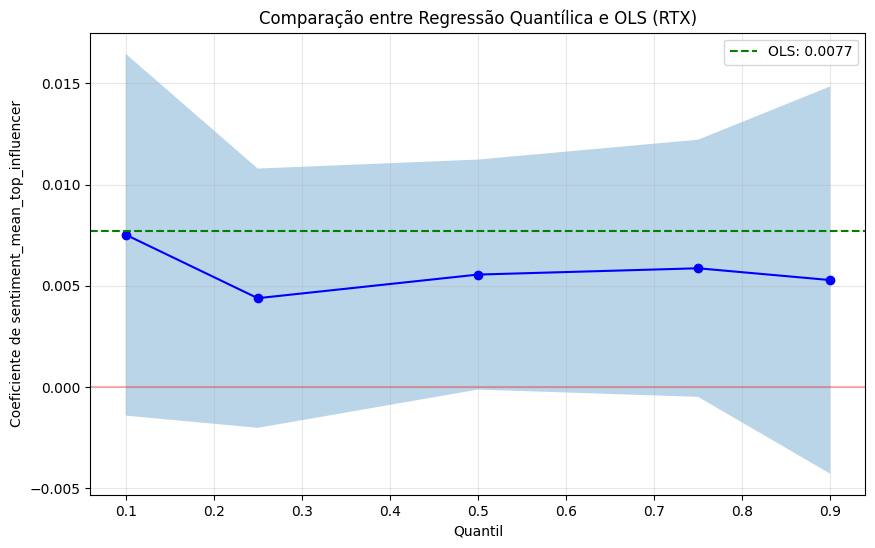

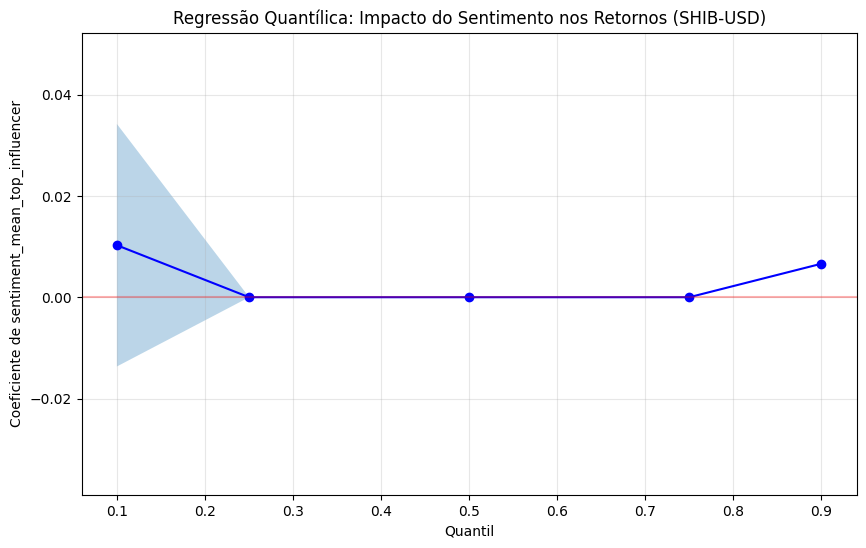

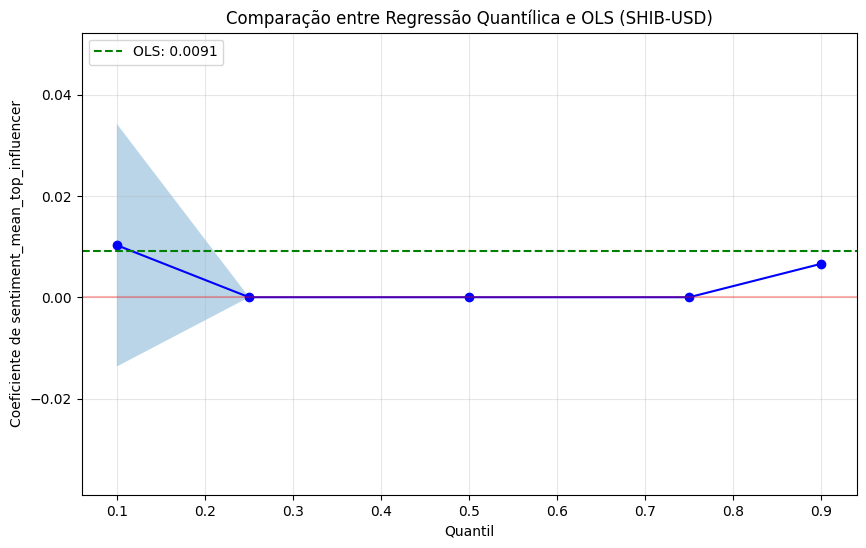

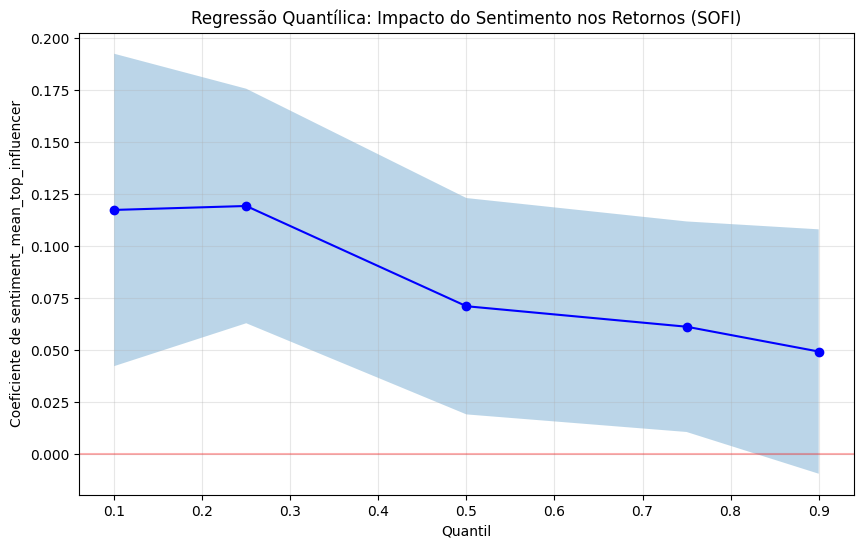

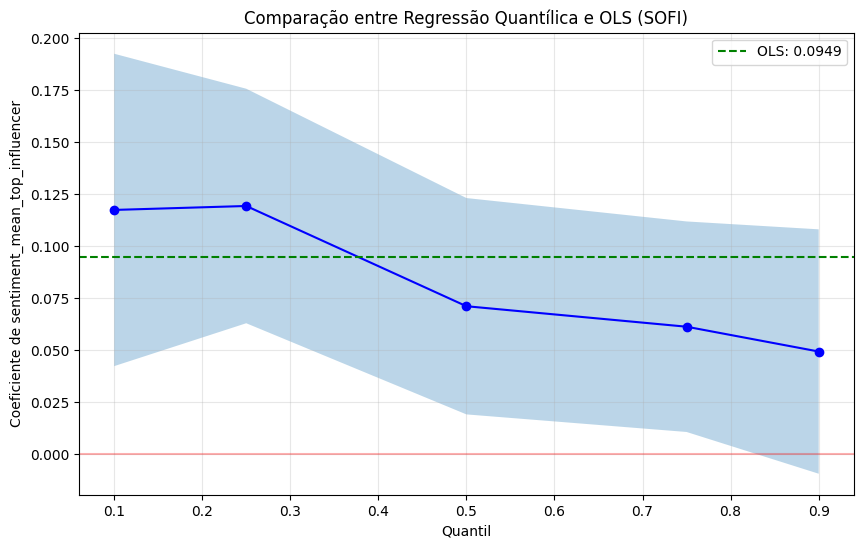

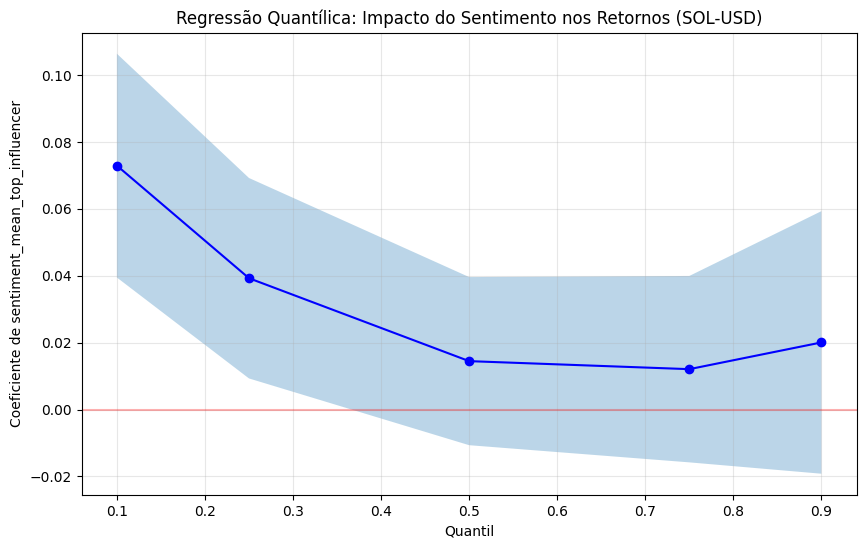

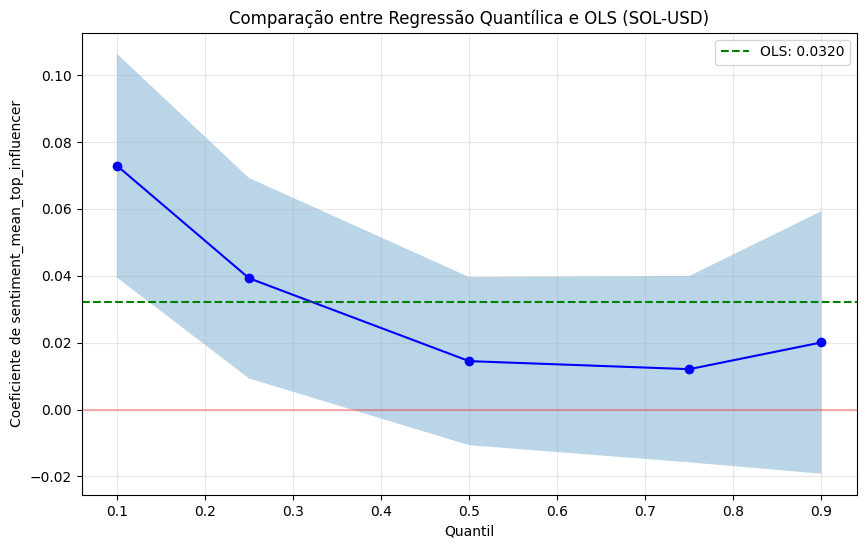

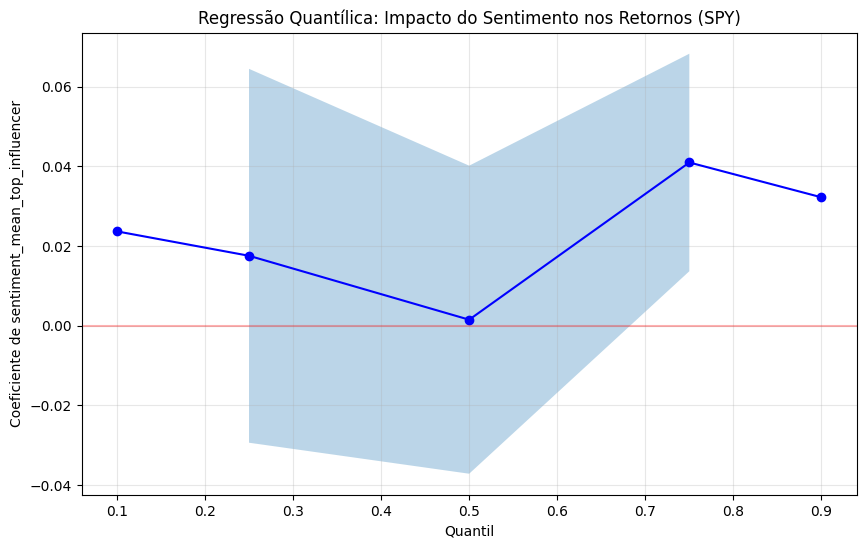

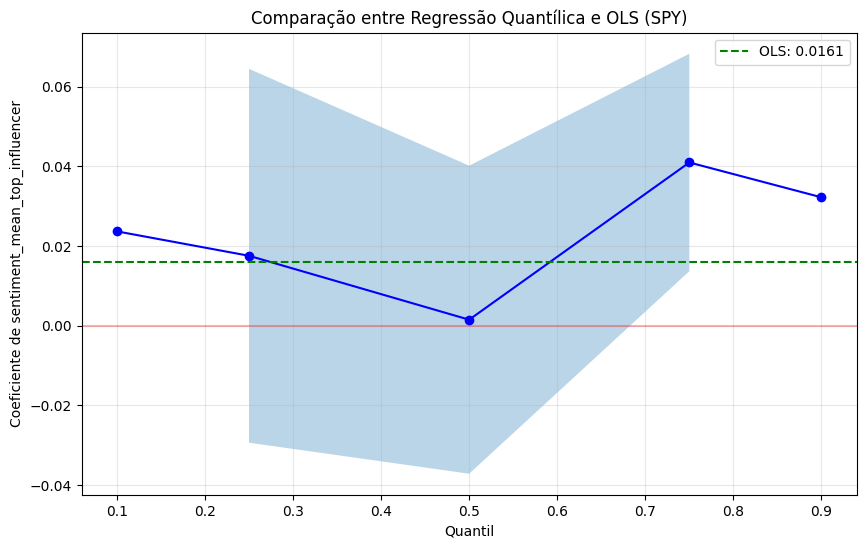

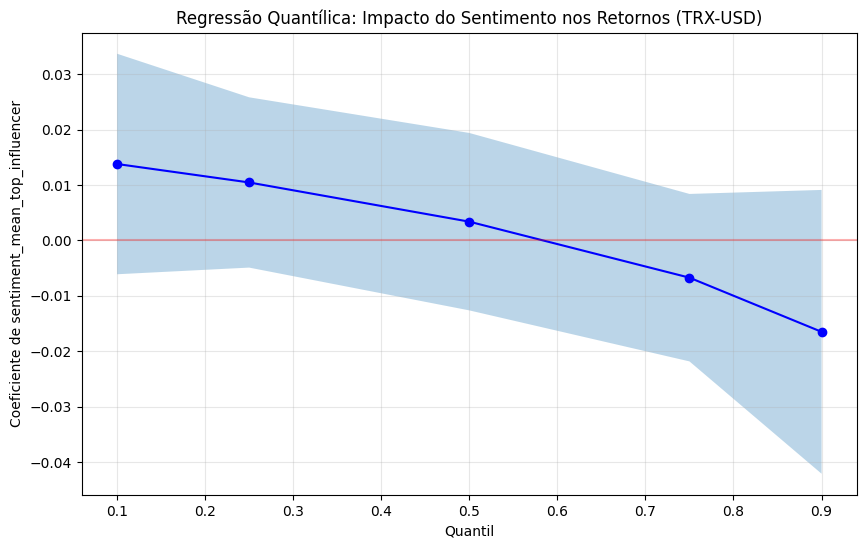

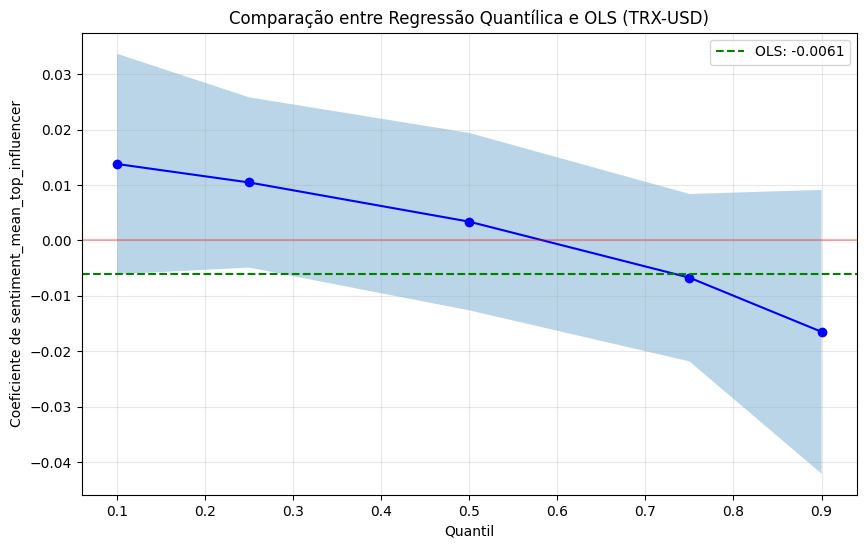

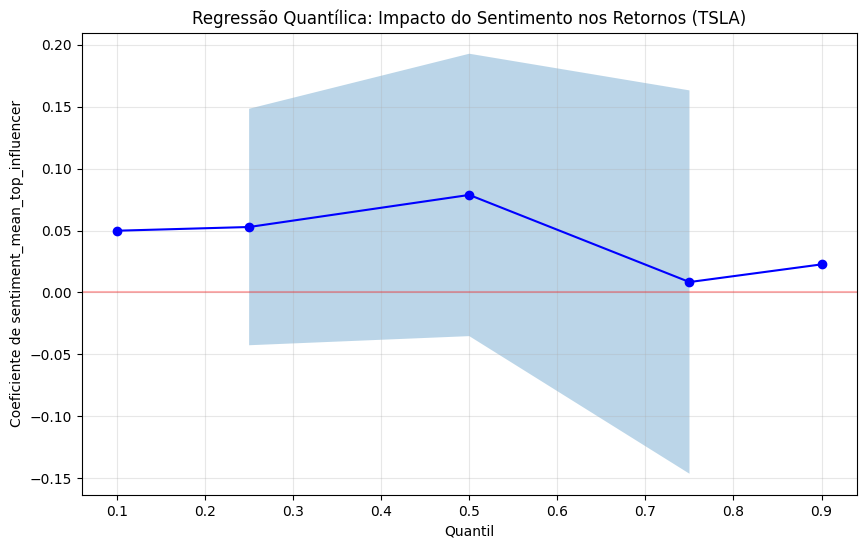

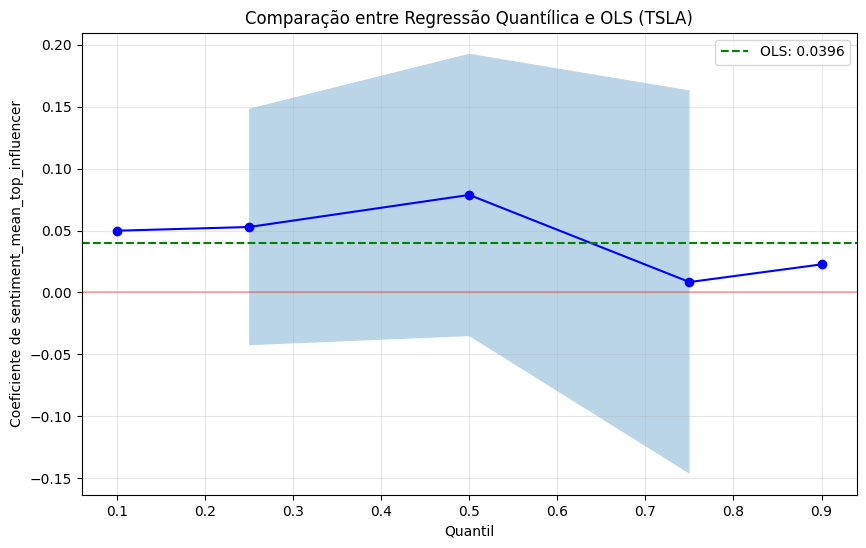

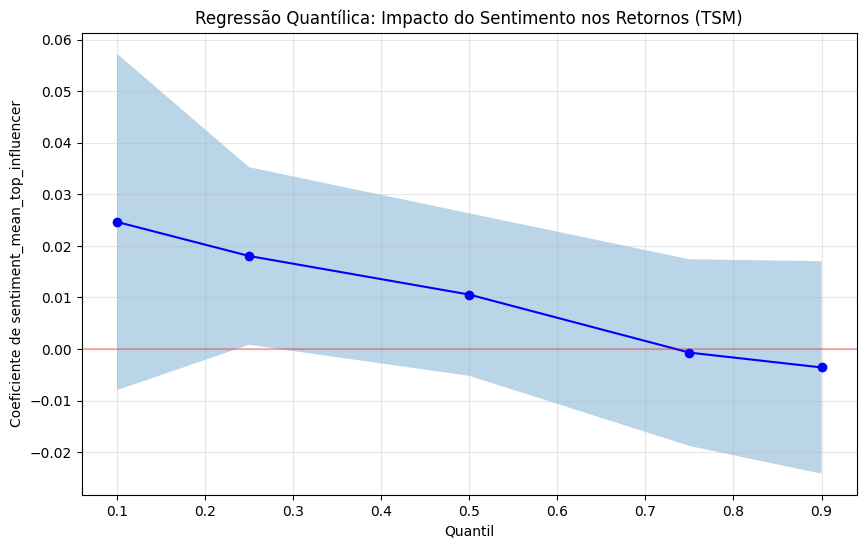

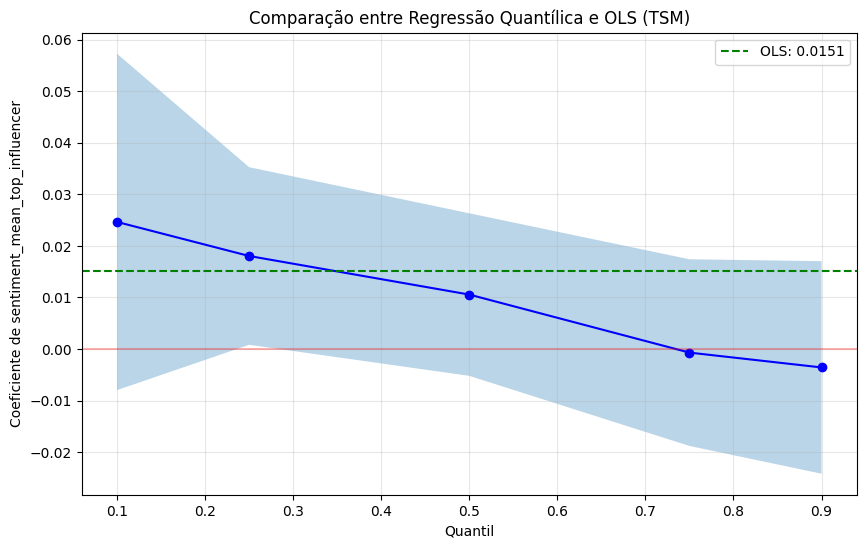

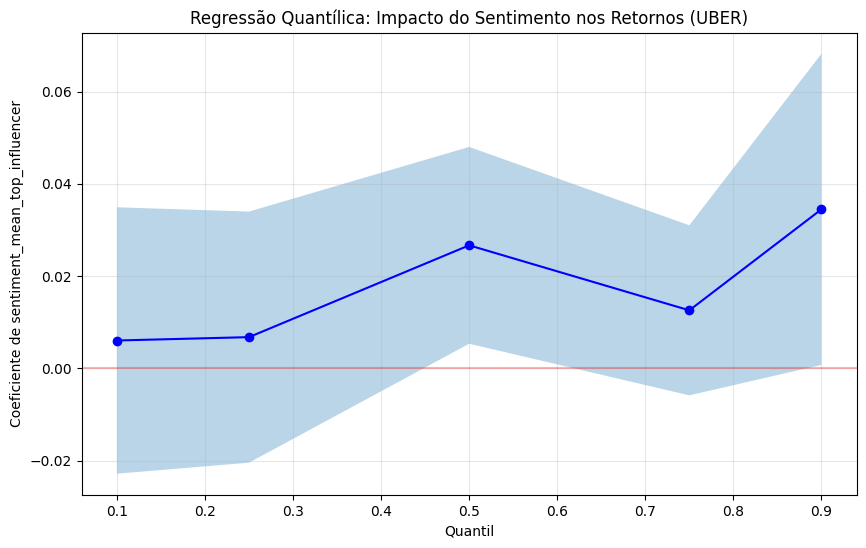

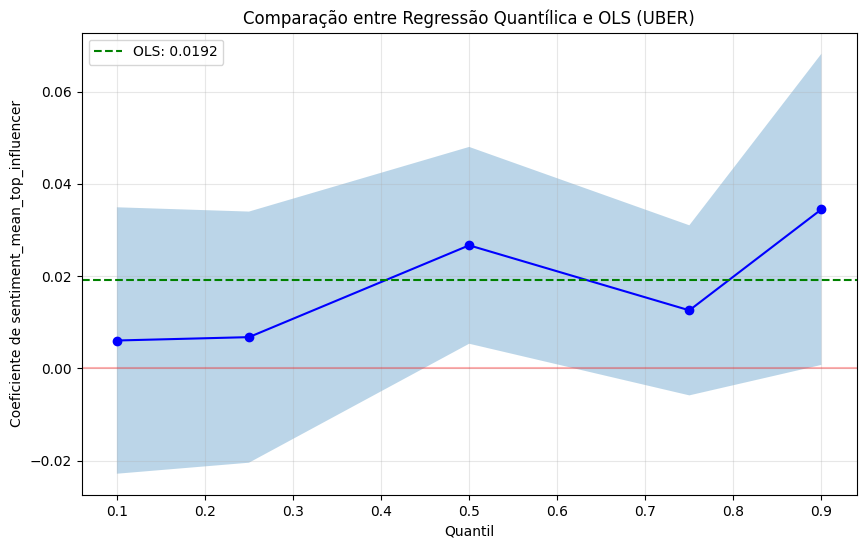

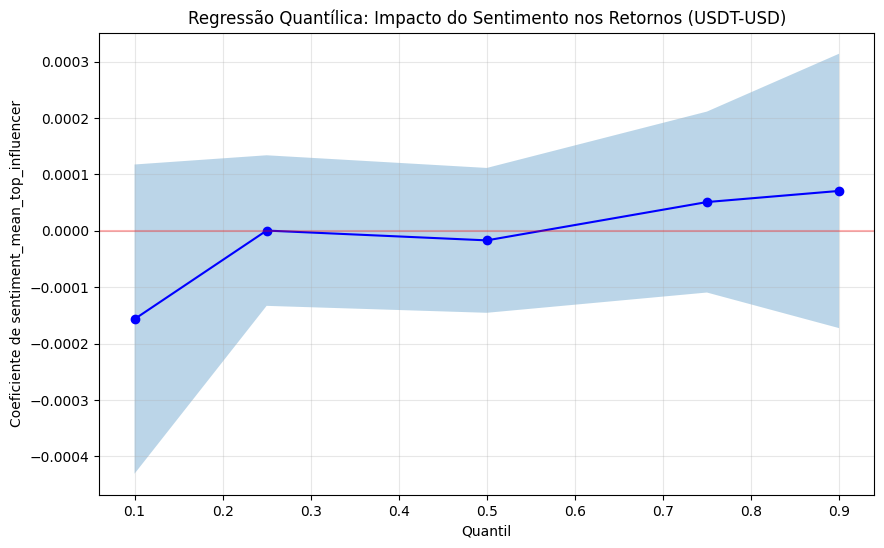

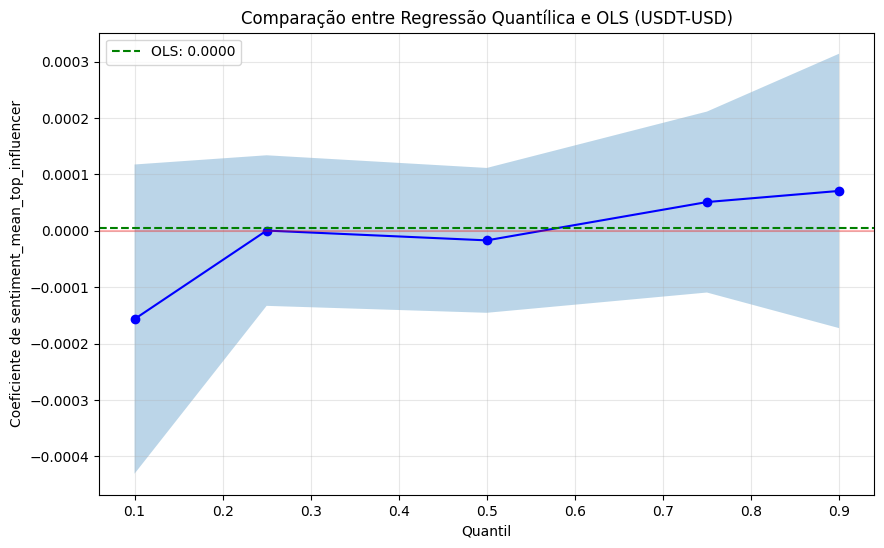

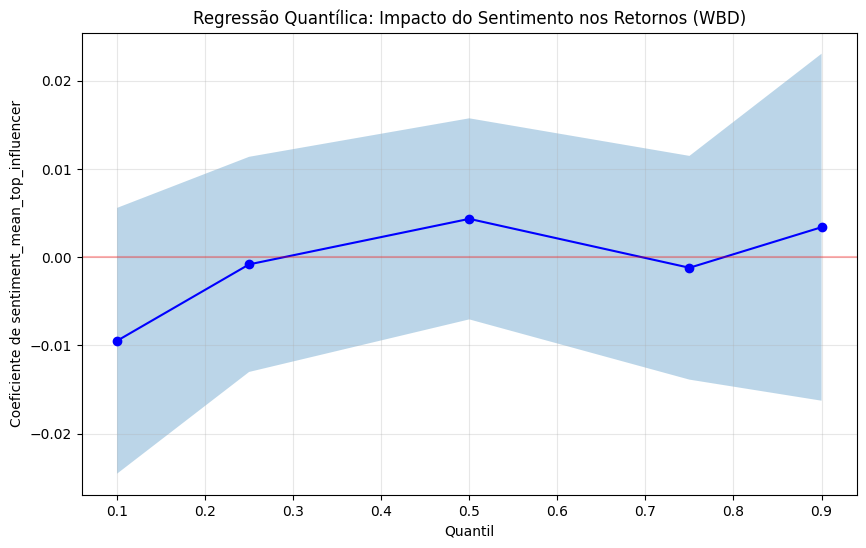

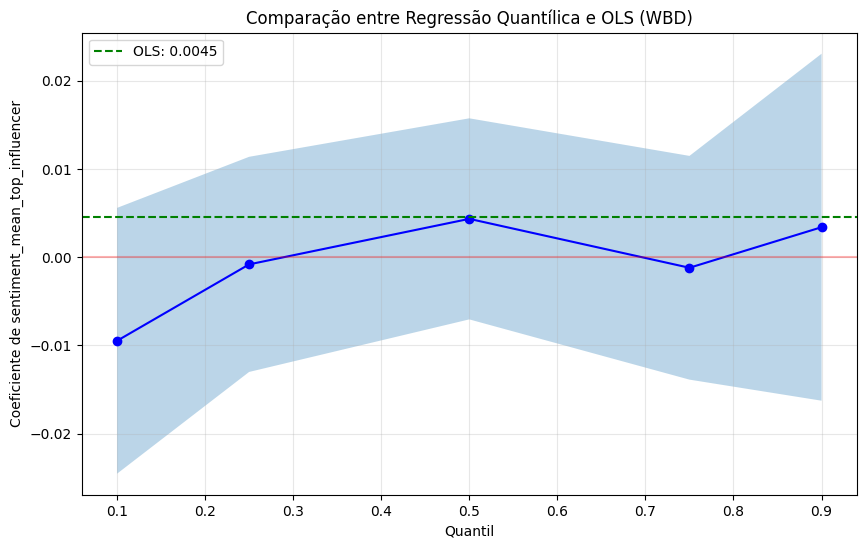

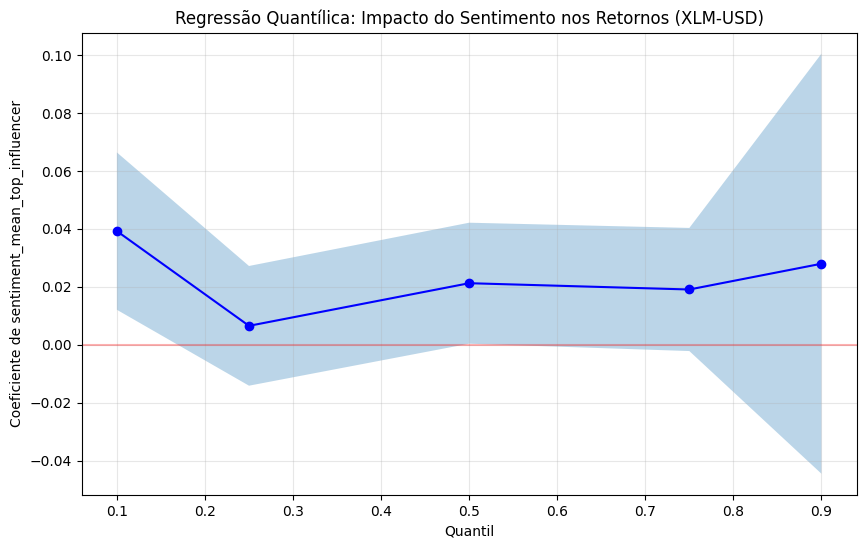

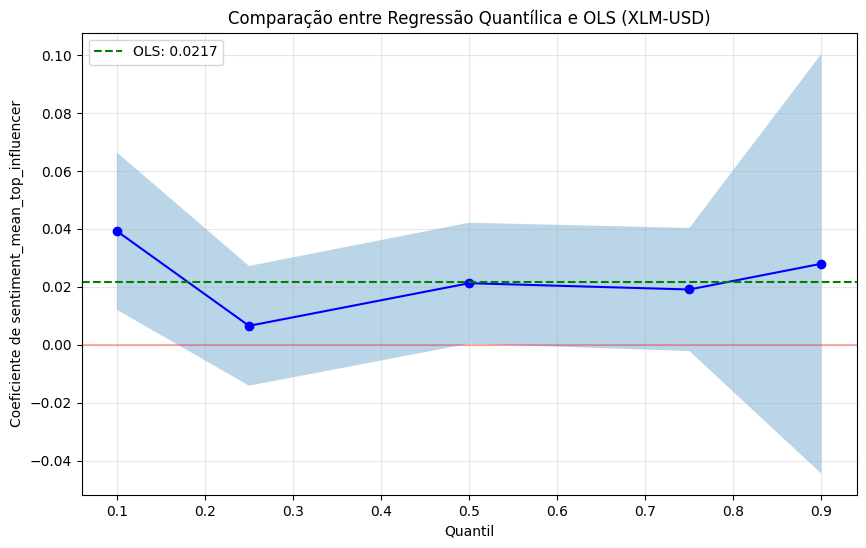

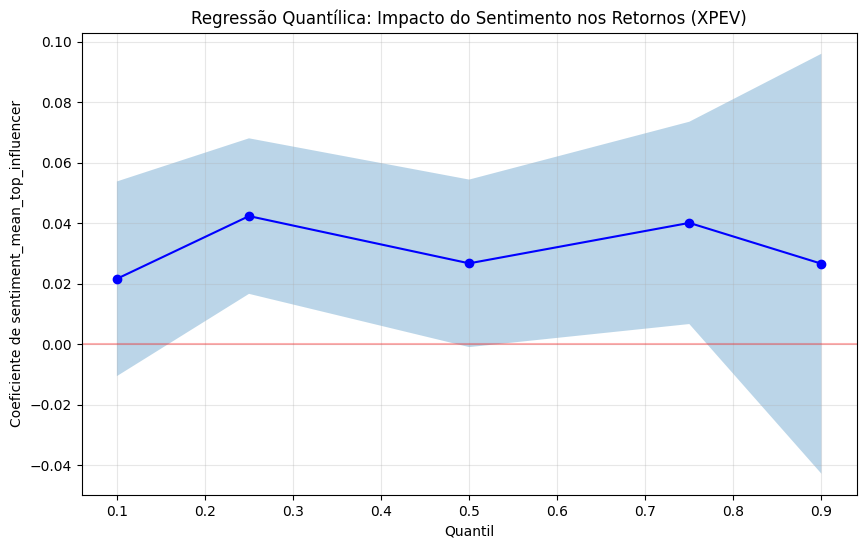

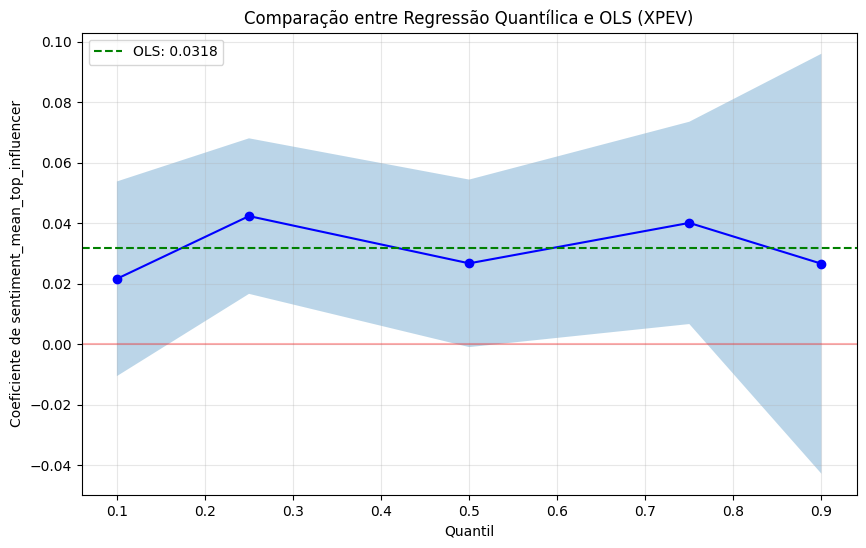

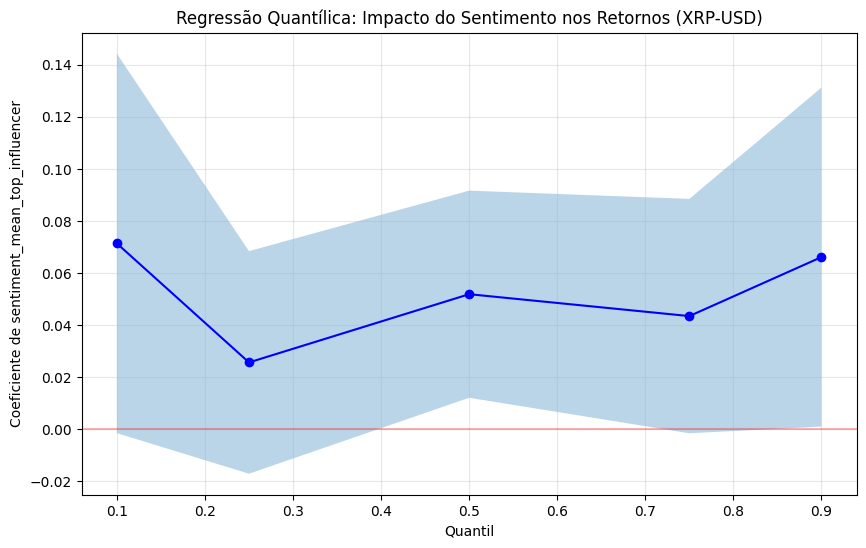

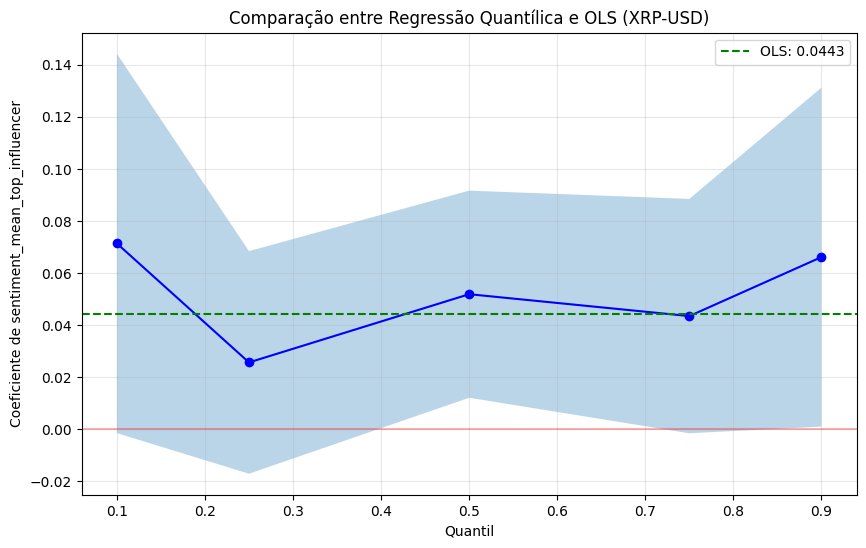

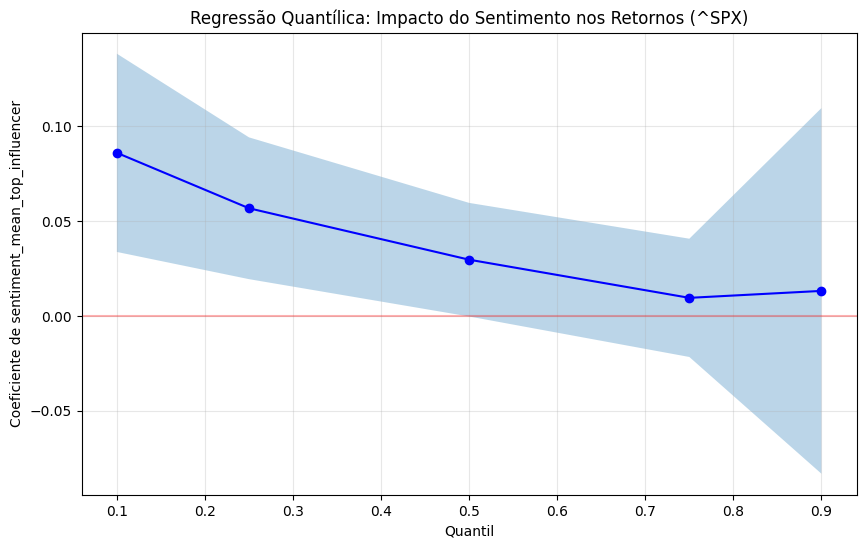

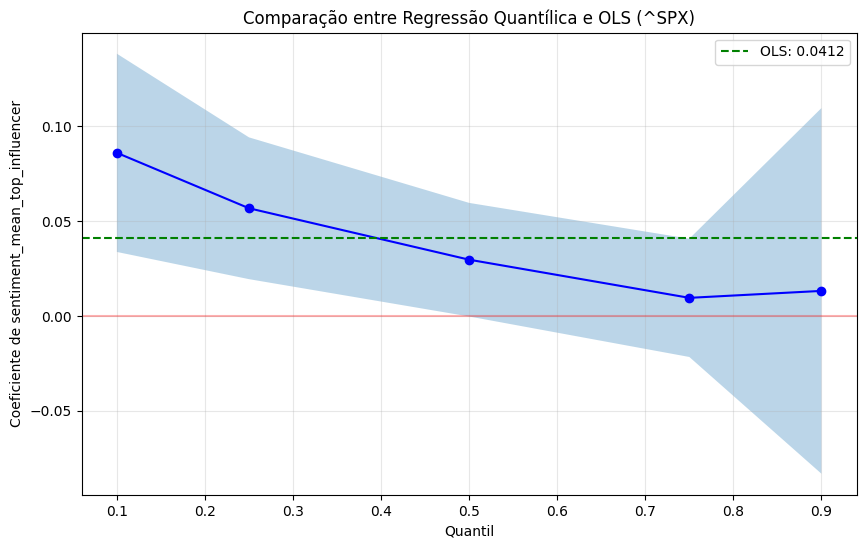

In [42]:
# Selecionar um símbolo para análise detalhada
symbols = all_combined_df['symbol'].unique()

for symbol in symbols:
    symbol_data = all_combined_df[all_combined_df['symbol'] == symbol].copy()

    # Preparar dados para regressão
    # Usar sentimento de influenciadores como variável independente
    X_var = 'sentiment_mean_top_influencer'
    y_var = 'Return'

    # Filtrar apenas linhas com ambos X_var e y_var não nulos
    regression_data = symbol_data[[X_var, y_var]].dropna()
    if regression_data.empty:
        print("Não há dados suficientes para regressão para este símbolo.")
    else:
        # Definir quantis para análise
        quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

        # Executar regressão quantílica para cada quantil
        models = {}
        for q in quantiles:
            model = smf.quantreg(f'{y_var} ~ {X_var}', data=regression_data)
            result = model.fit(q=q)
            models[q] = result
            print(f"Quantil {q}:")
            print(result.summary())

        # Visualizar coeficientes por quantil
        coefs = []
        for q in quantiles:
            coefs.append({
                'quantile': q,
                'coefficient': models[q].params[X_var],
                'lower_ci': models[q].conf_int().loc[X_var][0],
                'upper_ci': models[q].conf_int().loc[X_var][1]
            })

        coefs_df = pd.DataFrame(coefs)

        plt.figure(figsize=(10, 6))
        plt.plot(coefs_df['quantile'], coefs_df['coefficient'], 'bo-')
        plt.fill_between(coefs_df['quantile'], 
                        coefs_df['lower_ci'],
                        coefs_df['upper_ci'],
                        alpha=0.3)
        plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
        plt.xlabel('Quantil')
        plt.ylabel(f'Coeficiente de {X_var}')
        plt.title(f'Regressão Quantílica: Impacto do Sentimento nos Retornos ({symbol})')
        plt.grid(True, alpha=0.3)

        # Comparar com regressão OLS (mínimos quadrados ordinários)
        ols_model = smf.ols(f'{y_var} ~ {X_var}', data=regression_data).fit()
        print("Regressão OLS:")
        print(ols_model.summary())

        # Adicionar linha horizontal para o coeficiente OLS no gráfico
        plt.figure(figsize=(10, 6))
        plt.plot(coefs_df['quantile'], coefs_df['coefficient'], 'bo-')
        plt.fill_between(coefs_df['quantile'], 
                        coefs_df['lower_ci'],
                        coefs_df['upper_ci'],
                        alpha=0.3)
        plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
        plt.axhline(y=ols_model.params[X_var], color='g', linestyle='--', 
                    label=f'OLS: {ols_model.params[X_var]:.4f}')
        plt.xlabel('Quantil')
        plt.ylabel(f'Coeficiente de {X_var}')
        plt.title(f'Comparação entre Regressão Quantílica e OLS ({symbol})')
        plt.legend()
        plt.grid(True, alpha=0.3)